# **Code Structure**
Note: In order to mantain the code more readable and clear, we decided to move part of the code in the Appendix. The code is computationally heavy, mainly due to the Appendix part (~1 hour)

<br>

## 1 - Data Ingestion

<br>

## 2 - Data Exploration

<br>

## 3 - Baseline Model
*  Baseline
*  Personalized investment recommendations (in Appendix)
*  Business Impact Score (BIS) computation (in Appendix)

<br>

## 4 - Feature Engineering for Baseline Model
*  Single Feature study
*  Further Feature Engineering study (in Appendix)

<br>

## 5 - XGBoost
*   Best Model
*   Feature Engineering and hyperparameters tuning (in Appendix)

<br>

## 6 - Neural Network
*   Best Model
*   Hyperparameters tuning (in Appendix)

<br>

## 7 - Random Forest
*   Best Model
*   Hyperparameters tuning (in Appendix)
<br>

## 8 - Model Ensemble
*   Ensemble
*   BIS computation
<br>

## 9 - Products recommendation and Results for Best Model: XGBoost

<br>

## 10 - Appendix


## **0 - Colab Enviroment and Imports**

In [ ]:
# Mount Google Drive to access files
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except:
    print("Drive already mounted or not in Colab environment.")


Mounted at /content/drive


In [ ]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from scipy.stats import probplot
from scipy.stats import boxcox, probplot
from scipy.stats import chi2_contingency

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Fixing seed for reproducibility
seed = 42

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)


sns.set(style="whitegrid", palette="Blues_d")
colors = sns.color_palette("Blues_d")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

## **1 - Data Ingestion**



In [ ]:
# Define the file path in Google Drive
file_path = '/content/drive/MyDrive/FintechBusinessCases/BusinessCase2/Dataset/Dataset2_Needs_Commission.xlsx'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# Drop ID column as it's not needed for analysis
needs_df = needs_df.drop('ID', axis=1)

## **2 - Data Exploration**



### a) Data Summary

In [ ]:
# Getting a statistical summary while distinguishing numerical and categorical variables
def summarize_dataframe(df, metadata_df):
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))
    numerical, categorical = [], []

    for col in df.columns:
        series = df[col]
        dtype = series.dtype.name
        description = meta_dict.get(col, "N/A")
        missing = series.isna().sum()
        total = len(series)
        pct_missing = round(100 * missing / total, 1)

        if pd.api.types.is_numeric_dtype(series) and series.nunique() > 10 and not col.lower().startswith("id"):
            numerical.append({
                "Variable": col,
                "Description": description,
                "Data Type": dtype,
                "Mean": series.mean(),
                "Std": series.std(),
                "Min": series.min(),
                "Max": series.max(),
                "Missing": missing,
                "% Missing": pct_missing,
                "Zeros": (series == 0).sum()
            })
        else:
            categorical.append({
                "Variable": col,
                "Description": description,
                "Data Type": dtype,
                "Unique Values": series.nunique(),
                "Top": series.mode().iloc[0] if not series.mode().empty else "N/A",
                "Top Freq": series.value_counts().iloc[0] if not series.value_counts().empty else "N/A",
                "Missing": missing,
                "% Missing": pct_missing
            })

    return pd.DataFrame(numerical), pd.DataFrame(categorical)

# Split summaries
num_summary, cat_summary = summarize_dataframe(needs_df, metadata_df)

# Function for better display
def style_table(df, categorical=False):
    fmt = {
        "Mean": "{:.2f}",
        "Std": "{:.2f}",
        "Min": "{:.2f}",
        "Max": "{:.2f}",
        "% Missing": "{:.1f}%",
    } if not categorical else {
        "% Missing": "{:.1f}%"
    }

    return (
        df.style
        .format(fmt, na_rep="N/A")
        .set_table_styles([
            {"selector": "th", "props": [("text-align", "left"), ("font-weight", "bold")]},
            {"selector": "td", "props": [("text-align", "left"), ("padding", "4px 8px")]},
        ])
        .set_properties(subset=["Variable"], **{
            "font-family": "monospace",
            "width": "150px",
            "white-space": "nowrap"
        })
        .set_properties(subset=["Description"], **{
            "width": "400px",
            "white-space": "normal",
        })
        .hide(axis='index')
    )


# Display
print("NUMERICAL VARIABLES SUMMARY:")
display(style_table(num_summary))

print("\nCATEGORICAL VARIABLES SUMMARY:")
display(style_table(cat_summary, categorical=True))

NUMERICAL VARIABLES SUMMARY:


Variable,Description,Data Type,Mean,Std,Min,Max,Missing,% Missing,Zeros
Age,"Age, in years",int64,55.25,11.97,18.00,97.00,0,0.0%,0
FinancialEducation,Normalized level of Financial Education (estimate),float64,0.42,0.15,0.04,0.90,0,0.0%,0
RiskPropensity,Normalized Risk propensity from MIFID profile,float64,0.36,0.15,0.02,0.88,0,0.0%,0
Income,Income (thousands of euros); estimate,float64,62.99,44.36,1.54,365.32,0,0.0%,0
Wealth,Wealth (thousands of euros); sum of investments and cash accounts,float64,93.81,105.47,1.06,2233.23,0,0.0%,0



CATEGORICAL VARIABLES SUMMARY:


Variable,Description,Data Type,Unique Values,Top,Top Freq,Missing,% Missing
Gender,"Gender (Female = 1, Male = 0)",int64,2,0,2540,0,0.0%
FamilyMembers,Number of components,int64,5,2,2101,0,0.0%
IncomeInvestment,Boolean variable for Income investment; 1 = High propensity,int64,2,0,3082,0,0.0%
AccumulationInvestment,Boolean variable for Accumulation/growth investment; 1 = High propensity,int64,2,1,2566,0,0.0%


In [ ]:
# Summary for products
num_summary_products, cat_summary_products = summarize_dataframe(products_df, metadata_df)

print("NUMERICAL VARIABLES SUMMARY (PRODUCTS):")
display(style_table(num_summary_products))

print("\nCATEGORICAL VARIABLES SUMMARY (PRODUCTS):")
display(style_table(cat_summary_products, categorical=True))

NUMERICAL VARIABLES SUMMARY (PRODUCTS):


Variable,Description,Data Type,Mean,Std,Min,Max,Missing,% Missing,Zeros
Risk,Normalized Synthetic Risk Indicator,float64,0.35,0.26,0.02,0.88,0,0.0%,0
Commission,Total Expense Ratio per year,float64,0.01,0.01,0.00,0.03,0,0.0%,0



CATEGORICAL VARIABLES SUMMARY (PRODUCTS):


Variable,Description,Data Type,Unique Values,Top,Top Freq,Missing,% Missing
IDProduct,Product description,int64,14,1,1,0,0.0%
Type,"1 = Accumulation product, 0 = Income product",int64,2,1,9,0,0.0%


### b) Income Investment Classes Distribution

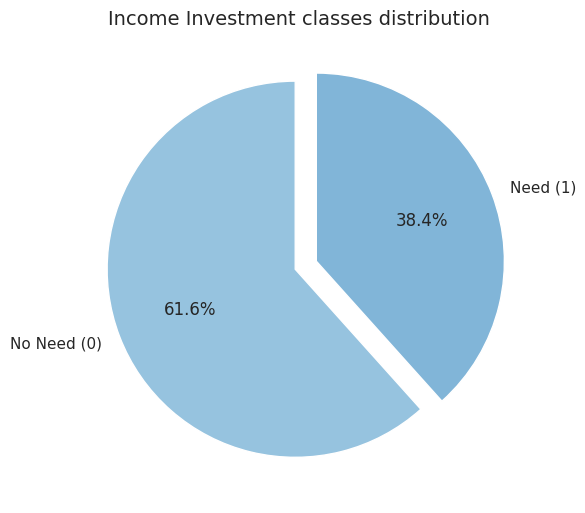

In [ ]:
# Plotting a pie chart for classes distribution
class_counts = needs_df['IncomeInvestment'].value_counts().sort_index()
labels = ['No Need (0)', 'Need (1)']
colors = sns.color_palette("Blues_d", n_colors=10)
explode = (0.02, 0.1)

plt.figure(figsize=(6, 6))
plt.pie(
    class_counts,
    labels=labels,
    colors=colors,
    explode=explode,
    autopct='%1.1f%%',
    startangle=90,
    shadow=False,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Income Investment classes distribution", fontsize=14)
plt.tight_layout()
plt.show()

### c) Wealth and Income Transformation



In [ ]:
# Create df for studying the transformation of income and wealth
transformed_df = needs_df.copy()

# Apply  transformations
transformed_df['Wealth_log'] = np.log1p(transformed_df['Wealth'])
transformed_df['Income_log'] = np.log1p(transformed_df['Income '])

# Apply Box-cox
# Boxcox can be applied only for positive values, as in our wealth and income data
wealth_data = needs_df['Wealth'].dropna()
income_data = needs_df['Income '].dropna()

wealth_boxcox, wealth_lambda = boxcox(wealth_data)
income_boxcox, income_lambda = boxcox(income_data)

# Create a new column for the transformed data
transformed_df['Wealth_boxcox'] = wealth_boxcox
transformed_df['Income_boxcox'] = income_boxcox

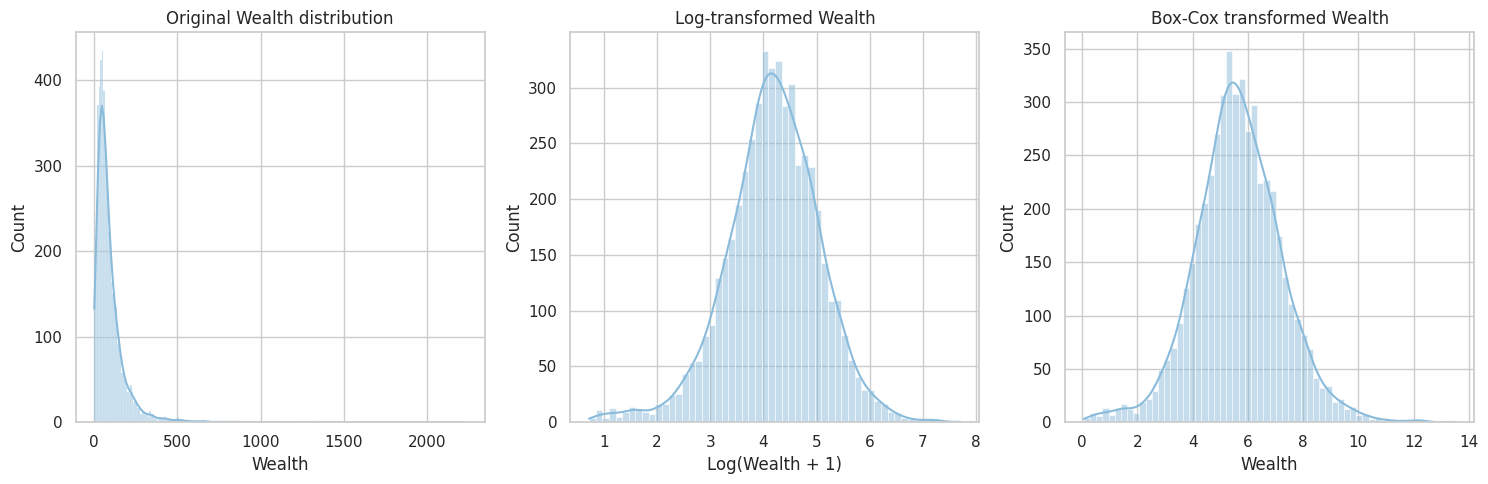

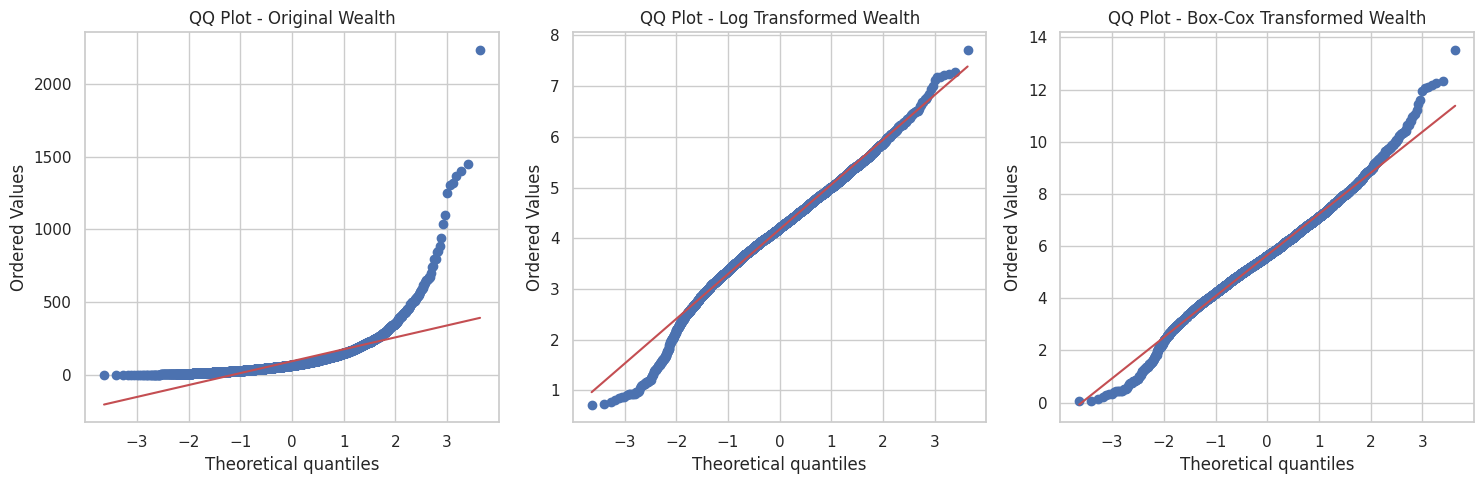

In [ ]:
# Wealth transformation analysis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original distribution
sns.histplot(needs_df.Wealth, kde=True, ax=ax1)
ax1.set_title('Original Wealth distribution')
ax1.set_xlabel('Wealth')

# Log transformation
sns.histplot(transformed_df['Wealth_log'], kde=True, ax=ax2)
ax2.set_title('Log-transformed Wealth')
ax2.set_xlabel('Log(Wealth + 1)')

# Power transformation
sns.histplot(transformed_df['Wealth_boxcox'], kde=True, ax=ax3)
ax3.set_title('Box-Cox transformed Wealth')
ax3.set_xlabel('Wealth')

plt.tight_layout()
plt.show()


# QQ plots for Wealth transformations
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original
probplot(needs_df['Wealth'].dropna(), dist="norm", plot=ax1)
ax1.set_title('QQ Plot - Original Wealth')

# Log-transformed
probplot(transformed_df['Wealth_log'].dropna(), dist="norm", plot=ax2)
ax2.set_title('QQ Plot - Log Transformed Wealth')

# Box-Cox transformed
probplot(transformed_df['Wealth_boxcox'], dist="norm", plot=ax3)
ax3.set_title('QQ Plot - Box-Cox Transformed Wealth')

plt.tight_layout()
plt.show()

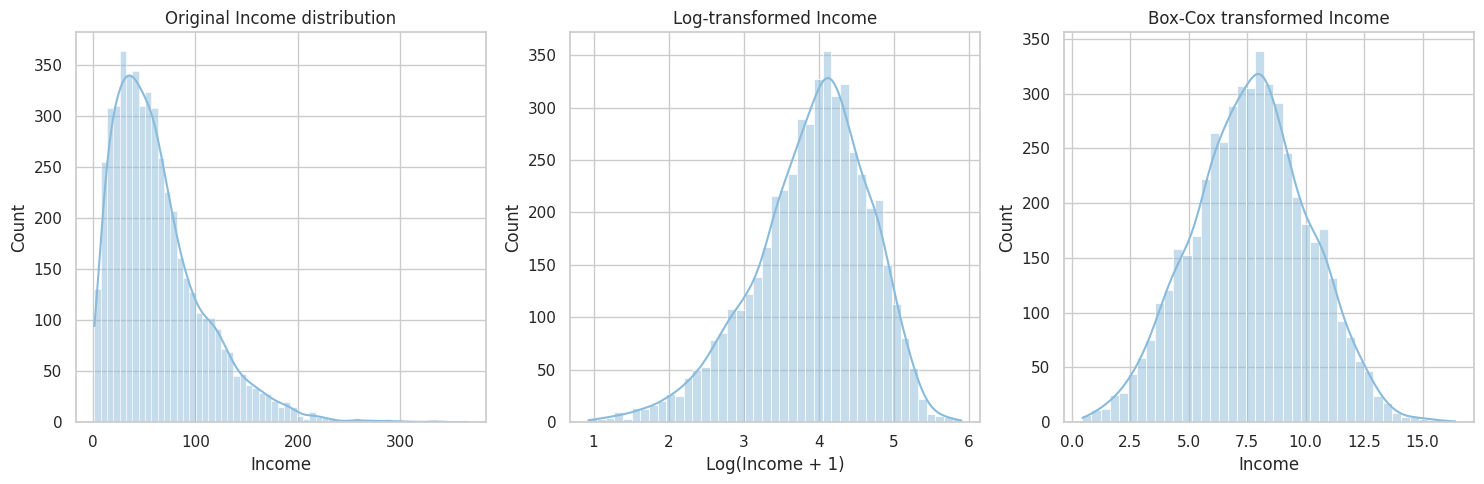

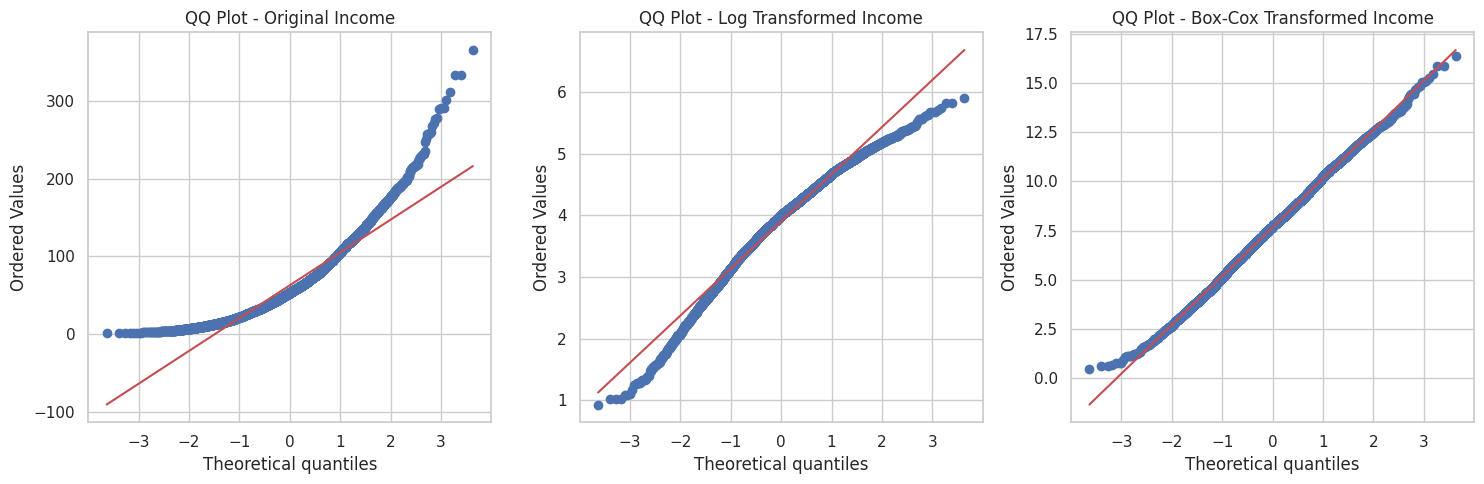

In [ ]:
# Income transformation analysis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original distribution
sns.histplot(needs_df['Income '] , kde=True, ax=ax1)
ax1.set_title('Original Income distribution')
ax1.set_xlabel('Income')

# Log transformation
sns.histplot(transformed_df['Income_log'], kde=True, ax=ax2)
ax2.set_title('Log-transformed Income')
ax2.set_xlabel('Log(Income + 1)')

# Power transformation
sns.histplot(transformed_df['Income_boxcox'], kde=True, ax=ax3)
ax3.set_title('Box-Cox transformed Income')
ax3.set_xlabel('Income')

plt.tight_layout()
plt.show()


# QQ plots for Wealth transformations
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original
probplot(needs_df['Income '].dropna(), dist="norm", plot=ax1)
ax1.set_title('QQ Plot - Original Income')

# Log-transformed
probplot(transformed_df['Income_log'].dropna(), dist="norm", plot=ax2)
ax2.set_title('QQ Plot - Log Transformed Income')

# Box-Cox transformed
probplot(transformed_df['Income_boxcox'], dist="norm", plot=ax3)
ax3.set_title('QQ Plot - Box-Cox Transformed Income')

plt.tight_layout()
plt.show()

### d) Scaling of Numerical Features

In [ ]:
# Maximum and minimum wealth
max_wealth_boxcox = np.max(transformed_df['Wealth_boxcox'])
min_wealth_boxcox = np.min(transformed_df['Wealth_boxcox'])

# Maximum and minimum risk propensity
max_risk_prop = np.max(transformed_df['RiskPropensity'])
min_risk_prop = np.min(transformed_df['RiskPropensity'])

# Select best variables
scaled_df = transformed_df.drop(['Wealth_log', 'Income_log', 'Wealth', 'Income '], axis=1)

# Apply MinMaxScaler to numerical variables
scaler = MinMaxScaler()
vars_to_normalize = ['Age', 'FamilyMembers', 'Wealth_boxcox', 'Income_boxcox']
scaled_df[vars_to_normalize] = scaler.fit_transform(scaled_df[vars_to_normalize])

### e) Correlation Matrix

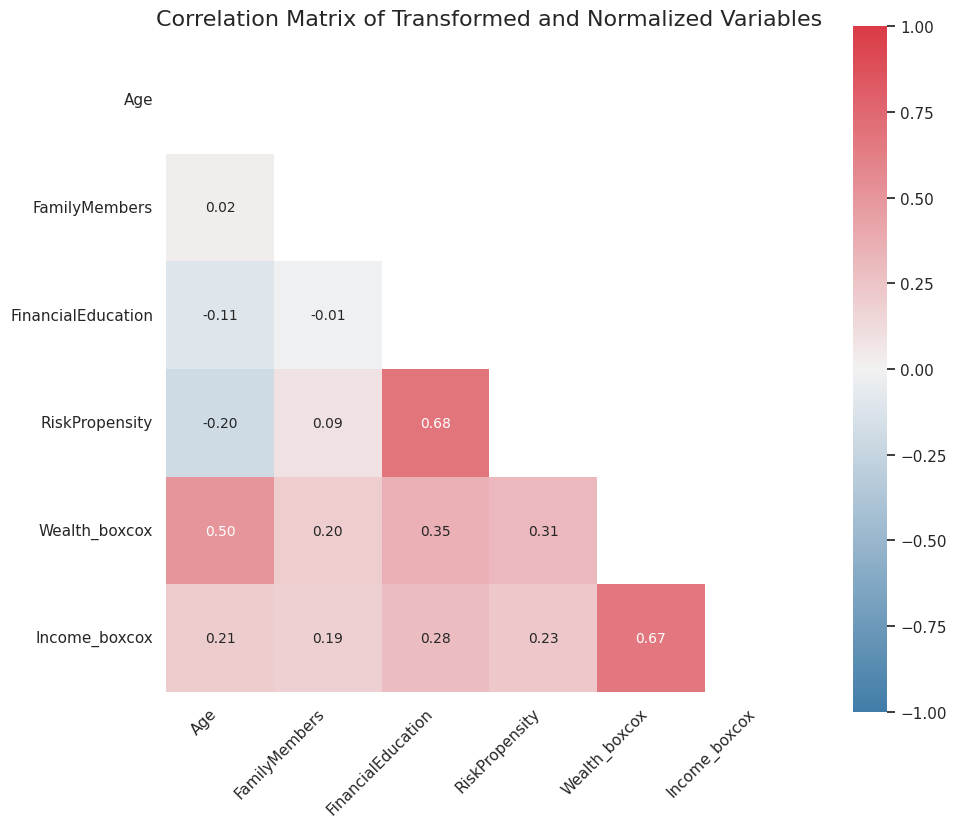

In [ ]:
sns.set_style("white")
# Get all numeric columns
numeric_cols = scaled_df.select_dtypes(include=['float64']).columns

# Compute correlation matrix
corr = scaled_df[numeric_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 10))

# Define a diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap without gridlines
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1, vmin=-1,
            center=0,
            square=True,
            linewidths=0,  # No gridlines
            cbar_kws={"shrink": .75},
            annot=True, fmt=".2f",
            annot_kws={"size": 10})

# Titles and layout
plt.title("Correlation Matrix of Transformed and Normalized Variables", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

### f) Joint Distribution Analysis





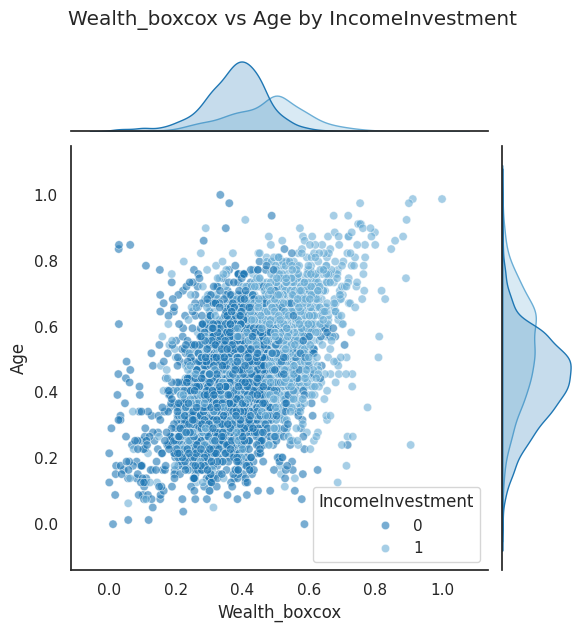

In [ ]:
custom_palette = ['#1f77b4', '#6baed6']

# Plot Wealth_boxcox vs Age by IncomeInvestment
sns.jointplot(data=scaled_df,
              x='Wealth_boxcox', y='Age',
              hue='IncomeInvestment',
              palette=custom_palette,
              kind='scatter', alpha=0.6)
plt.suptitle("Wealth_boxcox vs Age by IncomeInvestment", y=1.05)
plt.show()

### g) Boxplot

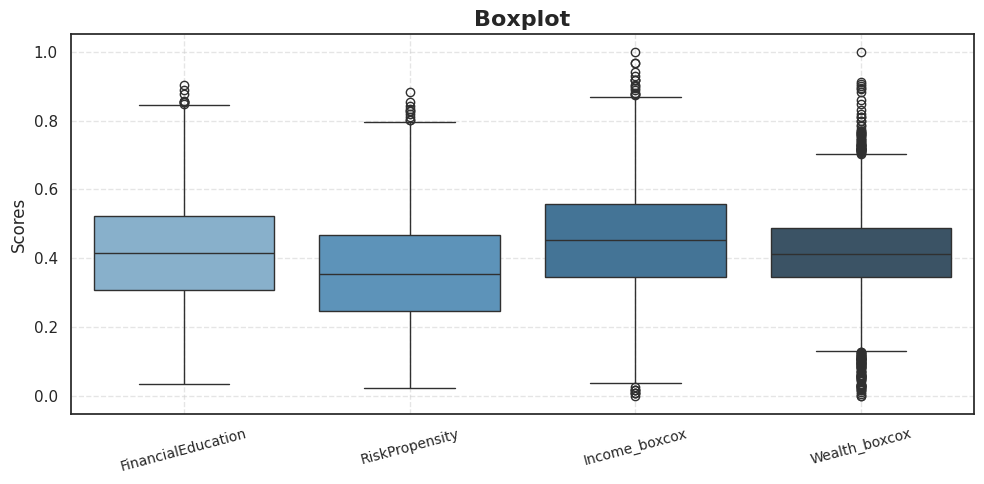

In [ ]:
# Boxplot of features that will be used in the baseline model
boxplot_features = ['FinancialEducation', 'RiskPropensity', 'Income_boxcox', 'Wealth_boxcox']

colors = sns.color_palette("Blues_d", n_colors=4)
plt.figure(figsize=(10, 5))
sns.boxplot(data=scaled_df[boxplot_features], palette=colors)
plt.title("Boxplot", fontsize=16, fontweight='bold')
plt.ylabel("Scores", fontsize=12)
plt.xticks(rotation=15, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### h) Risk Propensity of Clients with Income preference


By plotting the distribution of clients risk propensity, we recognize that there are values of risk propensity where the bank/asset manager is not offering products. So we decided to try to create them, in order to be able to better satisfy customers' need

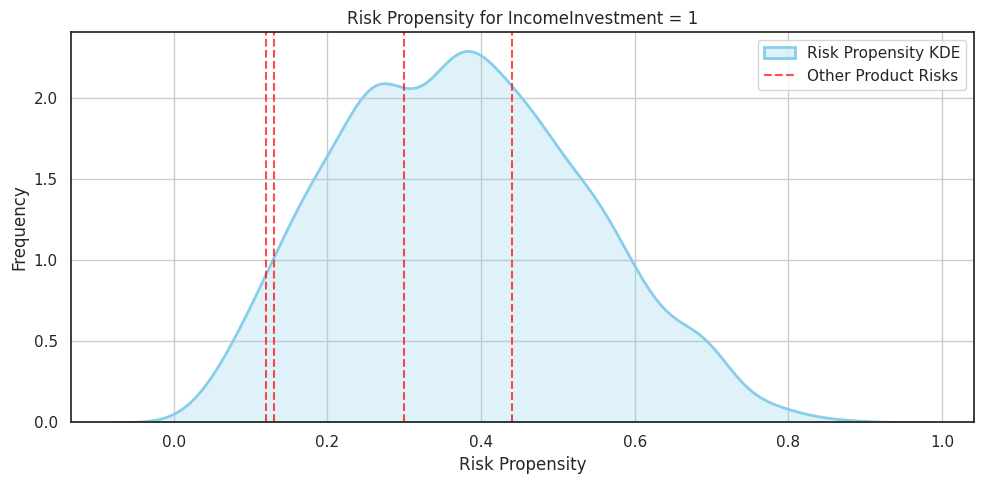

In [ ]:
# Filter the DataFrame selecting clients that want an income product
subset_income = scaled_df[scaled_df['IncomeInvestment'] == 1]

# Plot
plt.figure(figsize=(10, 5))
sns.kdeplot(subset_income['RiskPropensity'], color='skyblue', linewidth=2, fill=True, label='Risk Propensity KDE')
plt.title("Risk Propensity for IncomeInvestment = 1")
plt.xlabel("Risk Propensity")
plt.ylabel("Frequency")
plt.grid(True)

# Add vertical lines for Risk values where Type == 0
risk_values = products_df[products_df['Type'] == 0]['Risk'].values
risk_values.sort()

# Plot the rest of the lines in red
for risk_value in risk_values[1:]:
    plt.axvline(x=risk_value, color='red', linestyle='--', alpha=0.7, label='Other Product Risks')

# To avoid duplicate legend entries for the red lines
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.show()

## **3 - Baseline Model**


### a) Train and Evaluation Functions

In [ ]:
# Model training and evaluation function that implements cross-validation
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)
    cv_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred))

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    return {
        'cv_metrics': {
            metric: {
                'mean': np.mean(scores),
                'std': np.std(scores)
            } for metric, scores in cv_metrics.items()
        },
        'test_metrics': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        },
        'y_test_pred': y_test_pred
    }


# Display results function
def display_results_table(results_dict, model_name, feature_type):
    cv_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
        'CV Mean': [
            results_dict['cv_metrics']['accuracy']['mean'],
            results_dict['cv_metrics']['precision']['mean'],
            results_dict['cv_metrics']['recall']['mean'],
            results_dict['cv_metrics']['f1']['mean']
        ],
        'CV Std': [
            results_dict['cv_metrics']['accuracy']['std'],
            results_dict['cv_metrics']['precision']['std'],
            results_dict['cv_metrics']['recall']['std'],
            results_dict['cv_metrics']['f1']['std']
        ],
        'Test Set': [
            results_dict['test_metrics']['accuracy'],
            results_dict['test_metrics']['precision'],
            results_dict['test_metrics']['recall'],
            results_dict['test_metrics']['f1']
        ]
    }

    df = pd.DataFrame(cv_data)
    df = df.round(3)

    print(f"\n{model_name} - {feature_type}")
    print("=" * 60)
    print(tabulate(df, headers='keys', tablefmt='pretty'))

### b) Logistic Regression Model

In [ ]:
# Logistic regression dataset
lr_df = scaled_df.copy()

# Creating labels vector
y = lr_df['IncomeInvestment']

# Data split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(lr_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis = 1), y, test_size=0.2, random_state=seed, stratify=y)

In [ ]:
# Define models
models = {
    'Logistic_regression': LogisticRegression(),
}

# Use only income Investment data
target_name = "Income Investment"

print(f"\nTarget Variable: {target_name}")
print("=" * 80)

for model_name, model in models.items():
    results_baseline_lr = train_evaluate_model(X_train_lr, y_train_lr, X_test_lr, y_test_lr, model)
    display_results_table(results_baseline_lr, model_name, "Base Features")


Target Variable: Income Investment

Logistic_regression - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.772  | 0.015  |  0.749   |
| 1 | Precision |  0.773  | 0.011  |  0.753   |
| 2 |  Recall   |  0.574  | 0.037  |  0.516   |
| 3 |    F1     |  0.658  | 0.022  |  0.612   |
+---+-----------+---------+--------+----------+


### Products recommendation and Results for Baseline Logistic Regression in **Appendix A**

## **4 - Feature engineering with Baseline Model**

### a) Feature Engineering

In [ ]:
# Feature engineering dataset
# This dataset will be used in the following models. Each model uses its best combination of feature
feature_engineering_df = transformed_df.copy()

# Income-Wealth ratio
feature_engineering_df["Income_Wealth_ratio"] = np.log1p(feature_engineering_df["Income "] / feature_engineering_df["Wealth"])

# High Income dummy
threshold_income = feature_engineering_df["Income "].quantile(0.85)
feature_engineering_df["High_income"] = (feature_engineering_df["Income "] >= threshold_income).astype(int)

# High Wealth dummy
threshold_wealth = feature_engineering_df["Wealth"].quantile(0.85)
feature_engineering_df["High_wealth"] = (feature_engineering_df["Wealth"] >= threshold_wealth).astype(int)

# RiskProsperity-scaled Wealth
feature_engineering_df["RiskPropensity_Wealth"] = np.log1p(feature_engineering_df["RiskPropensity"] * feature_engineering_df["Wealth"])

# RiskProsperity-scaled Income
feature_engineering_df["RiskPropensity_Income"] = np.log1p(feature_engineering_df["RiskPropensity"] * feature_engineering_df["Income "])

# FinancialEducation-Age ratio
feature_engineering_df["FinEd_Age_ratio"] = feature_engineering_df["FinancialEducation"] / feature_engineering_df["Age"]

In [ ]:
# Scaling the dataset with engineered features
# Apply MinMaxScaler to numerical variables
scaler = MinMaxScaler()
vars_to_normalize = ['Age', 'FamilyMembers', 'Wealth_boxcox', 'Income_boxcox', 'Income_Wealth_ratio', 'RiskPropensity_Wealth', 'RiskPropensity_Income', 'FinEd_Age_ratio']
feature_engineering_df[vars_to_normalize] = scaler.fit_transform(feature_engineering_df[vars_to_normalize])

### b) Logistic Regression model

In [ ]:
# Data split dropping labels from the dataset
X_train_lr_eng, X_test_lr_eng, y_train_lr_eng, y_test_lr_eng = train_test_split(feature_engineering_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis = 1), y, test_size=0.2, random_state=seed, stratify=y)

# Define baseline features
baseline_features_lr = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',  'RiskPropensity', 'Wealth_boxcox', 'Income_boxcox']

# Define excluded features
excluded_features_lr = {'Wealth_log', 'Income_log', 'Income ', 'Wealth', 'IncomeInvestment', 'AccumulationInvestment'}

# Features to test one by one
candidate_features_lr = [
    f for f in feature_engineering_df.columns
    if f not in baseline_features_lr and f not in excluded_features_lr
]

# Define models
models = {
    'Logistic_regression': LogisticRegression(),
}

target_name = "Income Investment"

print(f"\nTarget Variable: {target_name}")
print("=" * 80)

# Loop over models
for model_name, model in models.items():
    # Baseline features
    X_train_base = X_train_lr_eng[baseline_features_lr]
    X_test_base = X_test_lr_eng[baseline_features_lr]
    results_base = train_evaluate_model(X_train_base, y_train_lr_eng, X_test_base, y_test_lr_eng, model)
    display_results_table(results_base, model_name, "Base Features")

    # Test each additional feature
    for extra_feature in candidate_features_lr:
        features = baseline_features_lr + [extra_feature]
        X_train_feat = X_train_lr_eng[features]
        X_test_feat = X_test_lr_eng[features]

        result_eng_lr = train_evaluate_model(X_train_feat, y_train_lr_eng, X_test_feat, y_test_lr_eng, model)
        display_results_table(result_eng_lr, model_name, f"Base + {extra_feature}")


Target Variable: Income Investment

Logistic_regression - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.772  | 0.015  |  0.749   |
| 1 | Precision |  0.773  | 0.011  |  0.753   |
| 2 |  Recall   |  0.574  | 0.037  |  0.516   |
| 3 |    F1     |  0.658  | 0.022  |  0.612   |
+---+-----------+---------+--------+----------+

Logistic_regression - Base + Income_Wealth_ratio
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.774  | 0.013  |  0.747   |
| 1 | Precision |  0.777  |  0.01  |  0.747   |
| 2 |  Recall   |  0.578  | 0.037  |  0.516   |
| 3 |    F1     |  0.662  | 0.022  |   0.61   |
+---+-----------+---------+--------+----------+

Logistic_regression - Base + High_income
+---+-----------+---------+--------+----------+
|   |  Metric   | C

### Further Feature Engineering study in **Appendix B**

## **5 - XGBoost Model**


#### Running best model
Performed an optimization procedure involving:

*   selection of the best set of engineered features
*   grid search over hyperparameters

Code available in the Appendix (section XGBoost)


In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Baseline features
baseline_features_XGB = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Wealth_boxcox', 'Income_boxcox']

# Engineered features
engineered_features_XGB = ['Income_Wealth_ratio']

# Use the best feature set output of our analysis
best_features_XGB = baseline_features_XGB + engineered_features_XGB
XGB_df = feature_engineering_df.copy()
XGB_df = XGB_df[best_features_XGB]

# Data split
X_train_XGB, X_test_XGB, y_train_XGB, y_test_XGB = train_test_split(XGB_df, y, test_size=0.2, random_state=seed, stratify=y)

# Best hyperparameter configuration
best_params_XGB = {'n_estimators': 200, 'learning_rate': 0.03, 'max_depth': 5}

# Instantiate the model with best parameters
best_model_XGB = XGBClassifier(
    **best_params_XGB,
    eval_metric='logloss',
    random_state=seed
)

# Train the best model
final_results_XGB = train_evaluate_model(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, best_model_XGB)

# Display final results
print(f"\nTarget Variable: Income Investment")
print("=" * 80)
display_results_table(final_results_XGB, "XGBoost", "Best Final Model")


Target Variable: Income Investment

XGBoost - Best Final Model
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.83   | 0.011  |  0.789   |
| 1 | Precision |  0.899  | 0.014  |  0.862   |
| 2 |  Recall   |  0.626  | 0.029  |  0.536   |
| 3 |    F1     |  0.737  | 0.021  |  0.661   |
+---+-----------+---------+--------+----------+


## **6 - Neural Network**



#### Running best model
Performed an optimization procedure involving:

*   optuna search over hyperparameters

Code available in the Appendix (section Neural Network)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### a) Dataset and Model Classes

In [ ]:
# Custom dataset class
class InvestmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_units, dropout):
        super(MLP, self).__init__()

        layers = []
        prev_size = input_size

        # Add hidden layers dynamically
        for _ in range(hidden_layers):
            layers.append(nn.Linear(prev_size, hidden_units))
            layers.append(nn.BatchNorm1d(hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_size = hidden_units

        # Output layer (No Sigmoid because we use BCEWithLogitsLoss)
        layers.append(nn.Linear(prev_size, 1))

        self.model = nn.Sequential(*layers)
        self.apply(self._init_weights)  # Apply weight initialization

    def forward(self, x):
        return self.model(x)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

### b) Train and Evaluation Function

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=20):
    best_loss = np.inf
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_true = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0).float().numpy())  # No sigmoid needed
                val_true.extend(y_batch.numpy())

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, "
                  f"Val Loss: {val_loss/len(val_loader):.4f}, "
                  f"Val Accuracy: {accuracy_score(val_true, val_preds):.4f}")


# Evaluation function
def evaluate_nn_metrics(model, data_loader):
    model.eval()
    all_preds, all_probs, all_true = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred_test = model(X_batch).squeeze()
            all_probs.extend(y_pred_test.numpy())  # Raw logits
            all_preds.extend((y_pred_test > 0).float().numpy())  # No Sigmoid
            all_true.extend(y_batch.numpy())

    metrics = {
        'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds),
        'recall': recall_score(all_true, all_preds),
        'f1': f1_score(all_true, all_preds),
    }

    return metrics, np.array(all_preds), np.array(all_probs)

In [ ]:
# Creating the dataframe with the best features
nn_features = ['Gender', 'Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Wealth_boxcox', 'Income_boxcox', 'Income_Wealth_ratio']
nn_df = feature_engineering_df.copy()
nn_df = nn_df[nn_features]

# Creating training, validation and test set as done for the baseline logistic model
X_train_val_nn, X_test_nn, y_train_val_nn, y_test_nn = train_test_split(nn_df, y, test_size=0.2, random_state=seed, stratify=y)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_val_nn, y_train_val_nn, test_size=0.2, random_state=seed, stratify=y_train_val_nn)

# Create the PyTorch datasets
train_dataset = InvestmentDataset(X_train_nn, y_train_nn)
val_dataset = InvestmentDataset(X_val_nn, y_val_nn)
test_dataset = InvestmentDataset(X_test_nn, y_test_nn)

### c) Neural Network Best Model

In [ ]:
# Loading the best parameters
best_params = {'hidden_layers': 3,
               'hidden_units': 212,
               'dropout': 0.11719087790054819,
               'lr': 0.0003308562948343823,
               'batch_size': 16}

# Create the PyTorch dataloader with the optimal batch size
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle = False)

# Define the dimension of the input layer
input_size = X_train_nn.shape[1]

# Define the best model
model = MLP(
    input_size=input_size,
    hidden_units=best_params['hidden_units'],
    hidden_layers=best_params['hidden_layers'],
    dropout=best_params['dropout']
)

# Compute class weights for BCEWithLogitsLoss
num_pos = np.sum(y_train_nn)
num_neg = len(y_train_nn) - num_pos
pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32)

# Define the loss and the optimazer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

# Training the best model
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=150, patience = 40)

Epoch 10, Train Loss: 0.7021, Val Loss: 0.7185, Val Accuracy: 0.7210
Epoch 20, Train Loss: 0.6935, Val Loss: 0.7257, Val Accuracy: 0.7330
Epoch 30, Train Loss: 0.6659, Val Loss: 0.7112, Val Accuracy: 0.7190
Epoch 40, Train Loss: 0.6646, Val Loss: 0.7199, Val Accuracy: 0.7210
Epoch 50, Train Loss: 0.6557, Val Loss: 0.7148, Val Accuracy: 0.7420
Epoch 60, Train Loss: 0.6320, Val Loss: 0.7237, Val Accuracy: 0.7330
Early stopping at epoch 69


In [ ]:
# Get metrics and predictions for validation and test
val_metrics_nn, y_val_pred_nn, y_val_prob_nn = evaluate_nn_metrics(model, val_loader)
test_metrics_nn, y_test_pred_nn, y_test_prob_nn = evaluate_nn_metrics(model, test_loader)

# Dataframe with results for validation and test set
metrics_df_nn = pd.DataFrame({
      'Validation': val_metrics_nn,
      'Test': test_metrics_nn
}).round(3)

# Display results
print(f"\nTarget Variable: Income Investment")
print(f"\nNeural Network")
print("=" * 60)
print(tabulate(metrics_df_nn, headers='keys', tablefmt='pretty'))


Target Variable: Income Investment

Neural Network
+-----------+------------+-------+
|           | Validation | Test  |
+-----------+------------+-------+
| accuracy  |   0.766    | 0.735 |
| precision |   0.729    | 0.694 |
|  recall   |   0.622    | 0.555 |
|    f1     |   0.671    | 0.616 |
+-----------+------------+-------+


## **7 - Random Forest**



In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Running best model
Performed an optimization procedure involving:

*   selection of the best set of engineered features
*   grid search over hyperparameters

Code available in the Appendix (section Random Forest)


In [ ]:
# Selecting best features for random forest
rf_features = ['Gender', 'Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Wealth_boxcox', 'Income_boxcox', 'Income_Wealth_ratio', 'RiskPropensity_Wealth', 'RiskPropensity_Income']
rf_df = feature_engineering_df.copy()
rf_df = rf_df[rf_features]

# Data split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(rf_df, y, test_size=0.2, random_state=seed, stratify=y)

# Define the best model
models = {
        'best_random_forest': RandomForestClassifier(
        n_estimators=425,
        max_depth=12,
        min_samples_split=18,
        min_samples_leaf=2,
        min_impurity_decrease = 0.0001,
        random_state=seed)
}

print(f"\nTarget Variable: Income Investment")
print("=" * 80)

for model_name, model in models.items():
    results_best_random_forest = train_evaluate_model(X_train_rf, y_train_rf, X_test_rf, y_test_rf, model)
    display_results_table(results_best_random_forest, model_name, "Final Random Forest")


Target Variable: Income Investment

best_random_forest - Final Random Forest
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.825  | 0.011  |  0.781   |
| 1 | Precision |  0.884  | 0.015  |  0.845   |
| 2 |  Recall   |  0.626  | 0.032  |  0.526   |
| 3 |    F1     |  0.732  |  0.02  |  0.648   |
+---+-----------+---------+--------+----------+


## **8 - Model Ensemble**

In this section we ensemble the most performing models on the test set

*   XGBoost
*   Neural Network
*   Random Forest





### a) Ensembling the models

In [ ]:
# Extracting the f1 score on test set
f1_nn = test_metrics_nn['f1']
f1_rf = results_best_random_forest['test_metrics']['f1']
f1_xgb = final_results_XGB['test_metrics']['f1']

# Computing the weghts
weights_sum = f1_nn + f1_rf + f1_xgb
w_nn = f1_nn / weights_sum
w_rf = f1_rf / weights_sum
w_xgb = f1_xgb / weights_sum

# Voting using the f1 score as weight (test set are built in order to contain the same observation)
y_test_pred_ensemble = ((w_nn * y_test_pred_nn + w_rf * results_best_random_forest['y_test_pred'] + w_xgb * final_results_XGB['y_test_pred']) > 0.7).astype(int)

In [ ]:
metrics_ensemble = {
  'accuracy': accuracy_score(y_test_pred_ensemble, y_test_rf),
  'precision': precision_score(y_test_pred_ensemble, y_test_rf),
  'recall': recall_score(y_test_pred_ensemble, y_test_rf),
  'f1': f1_score(y_test_pred_ensemble, y_test_rf)
}

print(f"\nPerformance on Test Set")
print("=" * 80)
for metric, value in metrics_ensemble.items():
    print(f"{metric.capitalize()}: {value:.3f}")


Performance on Test Set
Accuracy: 0.787
Precision: 0.518
Recall: 0.877
F1: 0.651


Even if the F1 of the ensemble is not satisfying, we compute the business metric since the high value of the recall (meaning that there are few false negative predictions) could have a good impact on it.

### b) BIS for the ensemble model

In [ ]:
# Filtering income products from our product database
income_products = products_df[products_df['Type'] == 0].copy()
min_risk = income_products['Risk'].min() # Will be used for risk matching later

In [ ]:
# Filter for clients predicted to need income products (y_pred == 1)
client_indices = np.where(y_test_pred_ensemble == 1)[0]

# Align indices between X_test and
X_base_test_reset = X_test_XGB.reset_index(drop=True)
target_client_ids = X_test_XGB.index[client_indices]
target_client_risk_propensity = X_base_test_reset.iloc[client_indices]['RiskPropensity'].values

In [ ]:
# Initialize lists to store recommendation results
nba_id_product = []
recommended_risk_level = []

# Extract product information for matching
product_ids = income_products['IDProduct'].astype(np.uint16).values
product_risks = income_products['Risk'].values

# Generate personalized recommendations for each target client
for client_risk in target_client_risk_propensity:
    if client_risk > min_risk:
        # Find products with acceptable risk (< customer's appetite)
        suitable_products = product_risks[product_risks < client_risk]

        if len(suitable_products) > 0:
            # Find the product with the highest risk among suitable ones
            max_suitable_risk = max(suitable_products)
            recommended_product_id = product_ids[product_risks == max_suitable_risk][0]
        else:
            recommended_product_id, max_suitable_risk = 0, 0
    else:
        recommended_product_id, max_suitable_risk = 0, 0

    nba_id_product.append(recommended_product_id)
    recommended_risk_level.append(max_suitable_risk)

# Create a recommendation matrix
nba = pd.DataFrame({
    'ClientID': target_client_ids,
    'RecommendedProductID': nba_id_product,
    'ClientRiskPropensity': target_client_risk_propensity,
    'ProductRiskLevel': recommended_risk_level
})


# Create a dictionary mapping product IDs to commission fees from products_df
product_fees = dict(zip(products_df['IDProduct'], products_df['Commission']))

# Add the commission values to your nba DataFrame first
nba['Commission'] = nba['RecommendedProductID'].map(product_fees).fillna(0)

In [ ]:
data = {
    'true': y_test_XGB,
    'pred': y_test_pred_ensemble,
    'Commission': np.zeros(len(y_test_XGB)),
    'Risk': X_base_test_reset['RiskPropensity'].values,
    'Wealth': X_base_test_reset['Wealth_boxcox'].values
}
df_final = pd.DataFrame(data)

# Ensure proper indexing: use the original client indices from X_test
nba_indexed = nba.set_index('ClientID')

# Assign commission fees only to clients in nba
df_final.loc[df_final['pred'] == 1, 'Commission'] = df_final.loc[df_final['pred'] == 1].index.map(nba_indexed['Commission']).fillna(0)

# Compute the mean commission from assigned values (excluding zeros)
mean_commission = np.mean(products_df['Commission'])

# Assign mean commission to all clients who still have 0
df_final.loc[df_final['Commission'] == 0, 'Commission'] = mean_commission



In [ ]:
def inverse_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.power(lmbda * y + 1, 1 / lmbda)

def reverse_transform(df, min_wealth, max_wealth, min_risk, max_risk):
    # Reverse the normalization (MinMaxScaler inverse)
    original_data = df.copy()

    # Step 1: Reverse the min-max scaling
    # MinMaxScaler transforms data to range [0,1] using: (x - min) / (max - min)
    # To reverse: x_original = x_scaled * (max - min) + min
    original_data['Wealth'] = original_data['Wealth'] * (max_wealth - min_wealth) + min_wealth
    original_data['Risk'] = original_data['Risk'] * (max_risk - min_risk) + min_risk

    # Step 2: Reverse the log transformation
    original_data['Wealth'] = inverse_boxcox(original_data['Wealth'], wealth_lambda)

    return original_data

In [ ]:
df_final = reverse_transform(df_final, min_wealth_boxcox, max_wealth_boxcox, min_risk_prop, max_risk_prop )

In [ ]:
def business_oriented_metric(df, alpha, beta):
    # Identify index groups based on conditions
    true_positives = df[(df['true'] == 1) & (df['pred'] == 1)]
    false_negatives = df[(df['true'] == 1) & (df['pred'] == 0)]
    false_positives = df[(df['true'] == 0) & (df['pred'] == 1)]

    # Compute the business-oriented metric
    metric_tp = (true_positives['Commission'] * true_positives['Wealth']).sum()
    metric_fn = (false_negatives['Commission'] * false_negatives['Wealth']).sum()
    metric_fp = (false_positives['Commission'] * false_positives['Wealth']).sum()

    return (metric_tp - alpha * metric_fn - beta * metric_fp)/(df.shape[0])

In [ ]:
# Compute the metric
alpha, beta = 1, 0.1
BIS_ensemble = business_oriented_metric(df_final, alpha, beta)
print(f"Business-Oriented Metric Score: {BIS_ensemble:.2f}")

Business-Oriented Metric Score: 0.47


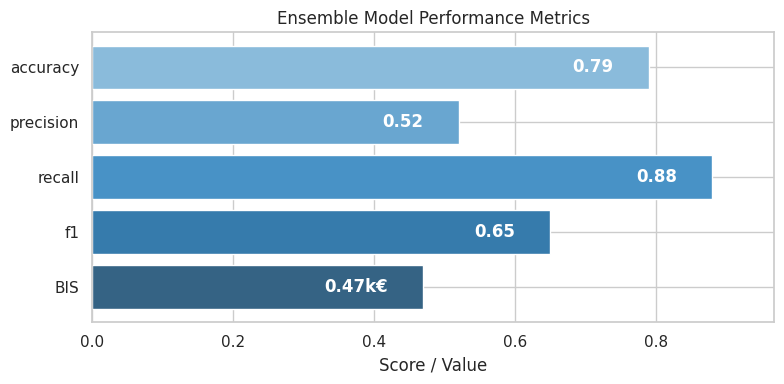

In [ ]:
# Metric values
metrics_ensemble = {
  'accuracy': accuracy_score(y_test_pred_ensemble, y_test_rf),
  'precision': precision_score(y_test_pred_ensemble, y_test_rf),
  'recall': recall_score(y_test_pred_ensemble, y_test_rf),
  'f1': f1_score(y_test_pred_ensemble, y_test_rf),
  "BIS": BIS_ensemble
}

# Extract names and values
names = list(metrics_ensemble.keys())
values = list(metrics_ensemble.values())

# Plot
plt.figure(figsize=(8, 4))
bars = plt.barh(names, values, color=colors)

# Determine dynamic x-axis limit
xmax = max(values) * 1.1
plt.xlim(0, xmax)
plt.xlabel("Score / Value")
plt.title("Ensemble Model Performance Metrics")

# Add value labels inside bars
for i, (name, v) in enumerate(zip(names, values)):
    if name == "BIS":
        label = f"{v:.2f}k€"
    else:
        label = f"{v:.2f}"
    plt.text(v - 0.05, i, label, va='center', ha='right', color='white', fontweight='bold')

# Invert Y-axis
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## **9 - Products recommendation and Results for Best Model: tuned XGBoost**

### a) Client-product matching based on risk profiles

In [ ]:
# Filtering income products from our product database
income_products = products_df[products_df['Type'] == 0].copy()
min_risk = income_products['Risk'].min() # Will be used for risk matching later

In [ ]:
# Filter for clients predicted to need income products (y_pred == 1)
client_indices = np.where(final_results_XGB['y_test_pred'] == 1)[0]

# Align indices between X_test and
X_base_test_reset = X_test_XGB.reset_index(drop=True)
target_client_ids = X_test_XGB.index[client_indices]
target_client_risk_propensity = X_base_test_reset.iloc[client_indices]['RiskPropensity'].values

As motivated above, we added a time-deposit product that allow the bank/asset manager to provide a financial product to the customers with a very low risk propensity

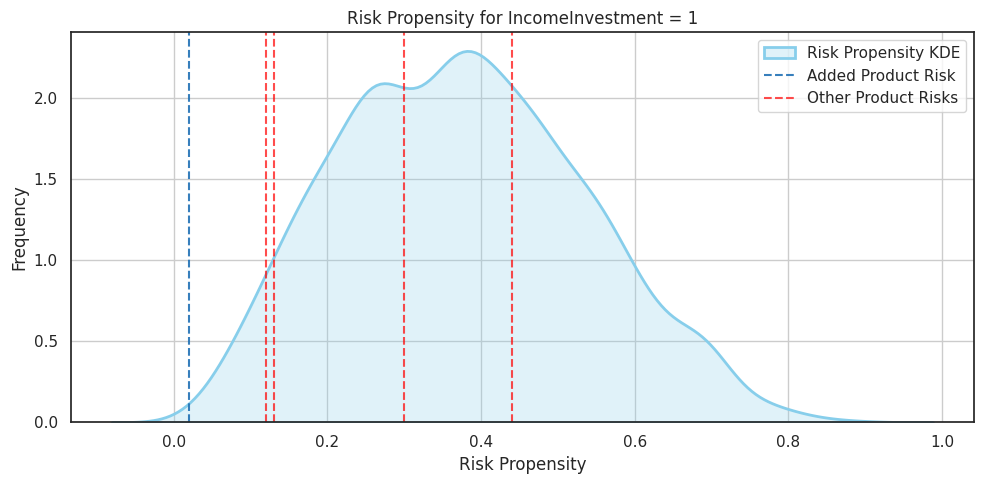

In [ ]:
# Filter the DataFrame
subset_income = scaled_df[scaled_df['IncomeInvestment'] == 1]

# Plot
plt.figure(figsize=(10, 5))
sns.kdeplot(subset_income['RiskPropensity'], color='skyblue', linewidth=2, fill=True, label='Risk Propensity KDE')

plt.title("Risk Propensity for IncomeInvestment = 1")
plt.xlabel("Risk Propensity")
plt.ylabel("Frequency")
plt.grid(True)

# Add vertical lines for Risk values where Type == 0
risk_values = products_df[products_df['Type'] == 0]['Risk'].values

risk_values.sort()

# Plot the first vertical line in a different color (e.g., green)
if len(risk_values) > 0:
    plt.axvline(x=risk_values[0], color='#2171b5', linestyle='--', alpha=0.9, label='Added Product Risk')

# Plot the rest of the lines in red
for risk_value in risk_values[1:]:
    plt.axvline(x=risk_value, color='red', linestyle='--', alpha=0.7, label='Other Product Risks')

# To avoid duplicate legend entries for the red lines
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

In [ ]:
# Initialize lists to store recommendation results
nba_id_product = []
recommended_risk_level = []

# Extract product information for matching
product_ids = income_products['IDProduct'].astype(np.uint16).values
product_risks = income_products['Risk'].values

# Generate personalized recommendations for each target client
for client_risk in target_client_risk_propensity:
    if client_risk > min_risk:
        # Find products with acceptable risk (< customer's appetite)
        suitable_products = product_risks[product_risks < client_risk]

        if len(suitable_products) > 0:
            # Find the product with the highest risk among suitable ones
            max_suitable_risk = max(suitable_products)
            recommended_product_id = product_ids[product_risks == max_suitable_risk][0]
        else:
            recommended_product_id, max_suitable_risk = 0, 0
    else:
        recommended_product_id, max_suitable_risk = 0, 0

    nba_id_product.append(recommended_product_id)
    recommended_risk_level.append(max_suitable_risk)

# Create a recommendation matrix
nba = pd.DataFrame({
    'ClientID': target_client_ids,
    'RecommendedProductID': nba_id_product,
    'ClientRiskPropensity': target_client_risk_propensity,
    'ProductRiskLevel': recommended_risk_level
})


# Create a dictionary mapping product IDs to commission fees from products_df
product_fees = dict(zip(products_df['IDProduct'], products_df['Commission']))

# Add the commission values to your nba DataFrame first
nba['Commission'] = nba['RecommendedProductID'].map(product_fees).fillna(0)

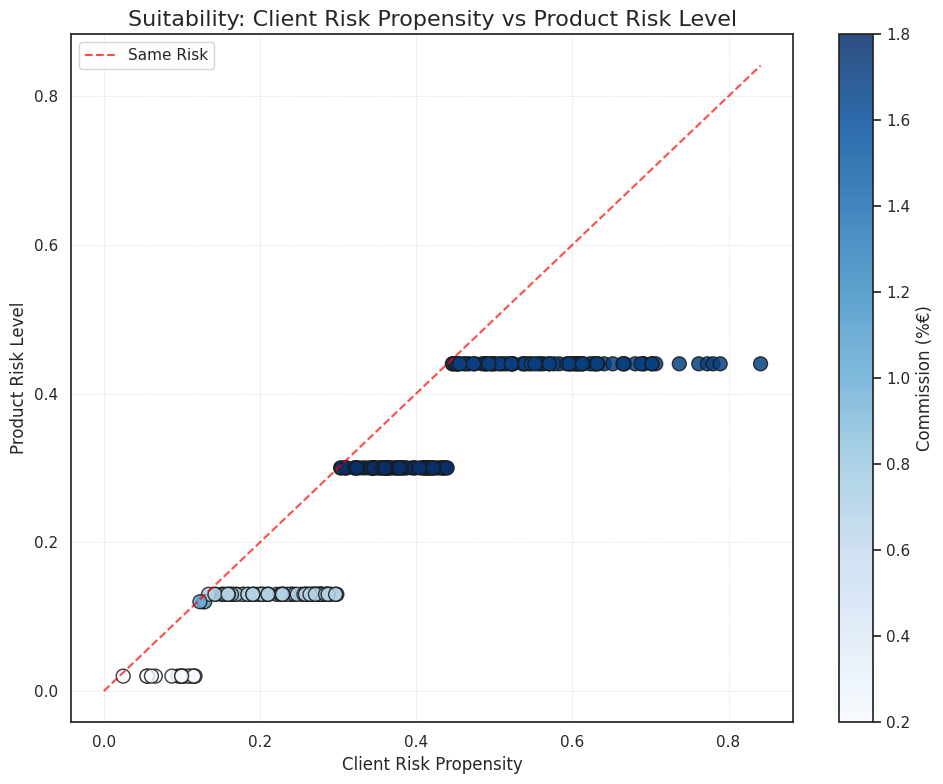

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    nba['ClientRiskPropensity'],
    nba['ProductRiskLevel'],
    c=nba['Commission']*100,
    cmap='Blues',
    edgecolor='k',
    alpha=0.85,
    s=100
)
# Add reference line for perfect risk matching
max_val = max(nba['ClientRiskPropensity'].max(), nba['ProductRiskLevel'].max())
plt.colorbar(scatter, label='Commission (%€)')
plt.plot([0, max_val], [0, max_val], 'red', linestyle='--', alpha=0.7, label='Same Risk')
plt.title('Suitability: Client Risk Propensity vs Product Risk Level', fontsize=16)
plt.xlabel('Client Risk Propensity', fontsize=12)
plt.ylabel('Product Risk Level', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


### b) Analyzing recommendation results


In [ ]:
# Selecting the description of each financial product from the Metadata dataset
product_data = metadata_df.iloc[19:33]

# Create the dictionary for the legend
product_legend = dict(zip(product_data.iloc[:, 0], product_data.iloc[:, 1]))


Recommendation Statistics:
Total customers requiring an Income product (y_pred=1): 239
Customers with valid recommendations: 239 (100.0%)
Customers without suitable recommendations: 0 (0.0%)


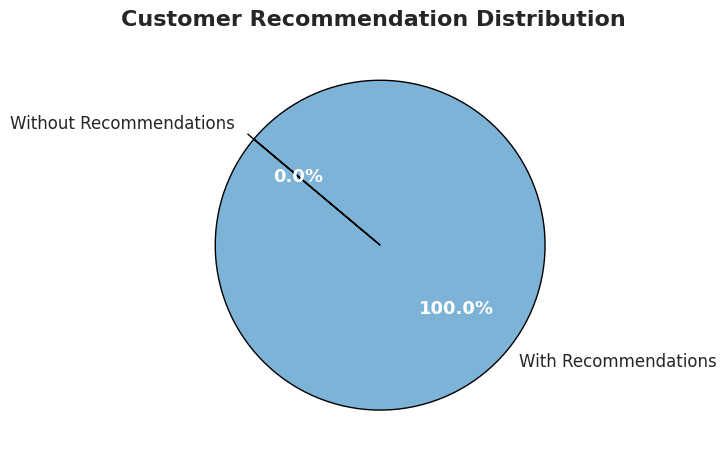

In [ ]:
total_clients = len(nba)
clients_with_recommendations = len(nba[nba['RecommendedProductID'] > 0])
percentage_with_recommendations = (clients_with_recommendations / total_clients) * 100

print("\nRecommendation Statistics:")
print(f"Total customers requiring an Income product (y_pred=1): {total_clients}")
print(f"Customers with valid recommendations: {clients_with_recommendations} ({percentage_with_recommendations:.1f}%)")
print(f"Customers without suitable recommendations: {total_clients - clients_with_recommendations} ({100-percentage_with_recommendations:.1f}%)")

# Pie chart of recommendation status
labels = ['With Recommendations', 'Without Recommendations']
sizes = [clients_with_recommendations, total_clients - clients_with_recommendations]
colors = colors
explode = (0.05, 0)

plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors,
                                   autopct='%1.1f%%', startangle=140,
                                   explode=explode, wedgeprops={'edgecolor': 'black'},
                                   textprops={'fontsize': 12})

plt.setp(autotexts, size=13, weight="bold", color='white')
plt.setp(texts, size=12)

plt.title('Customer Recommendation Distribution', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()



<ipython-input-49-592594c4d227>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recommendation_counts.index.astype(str),


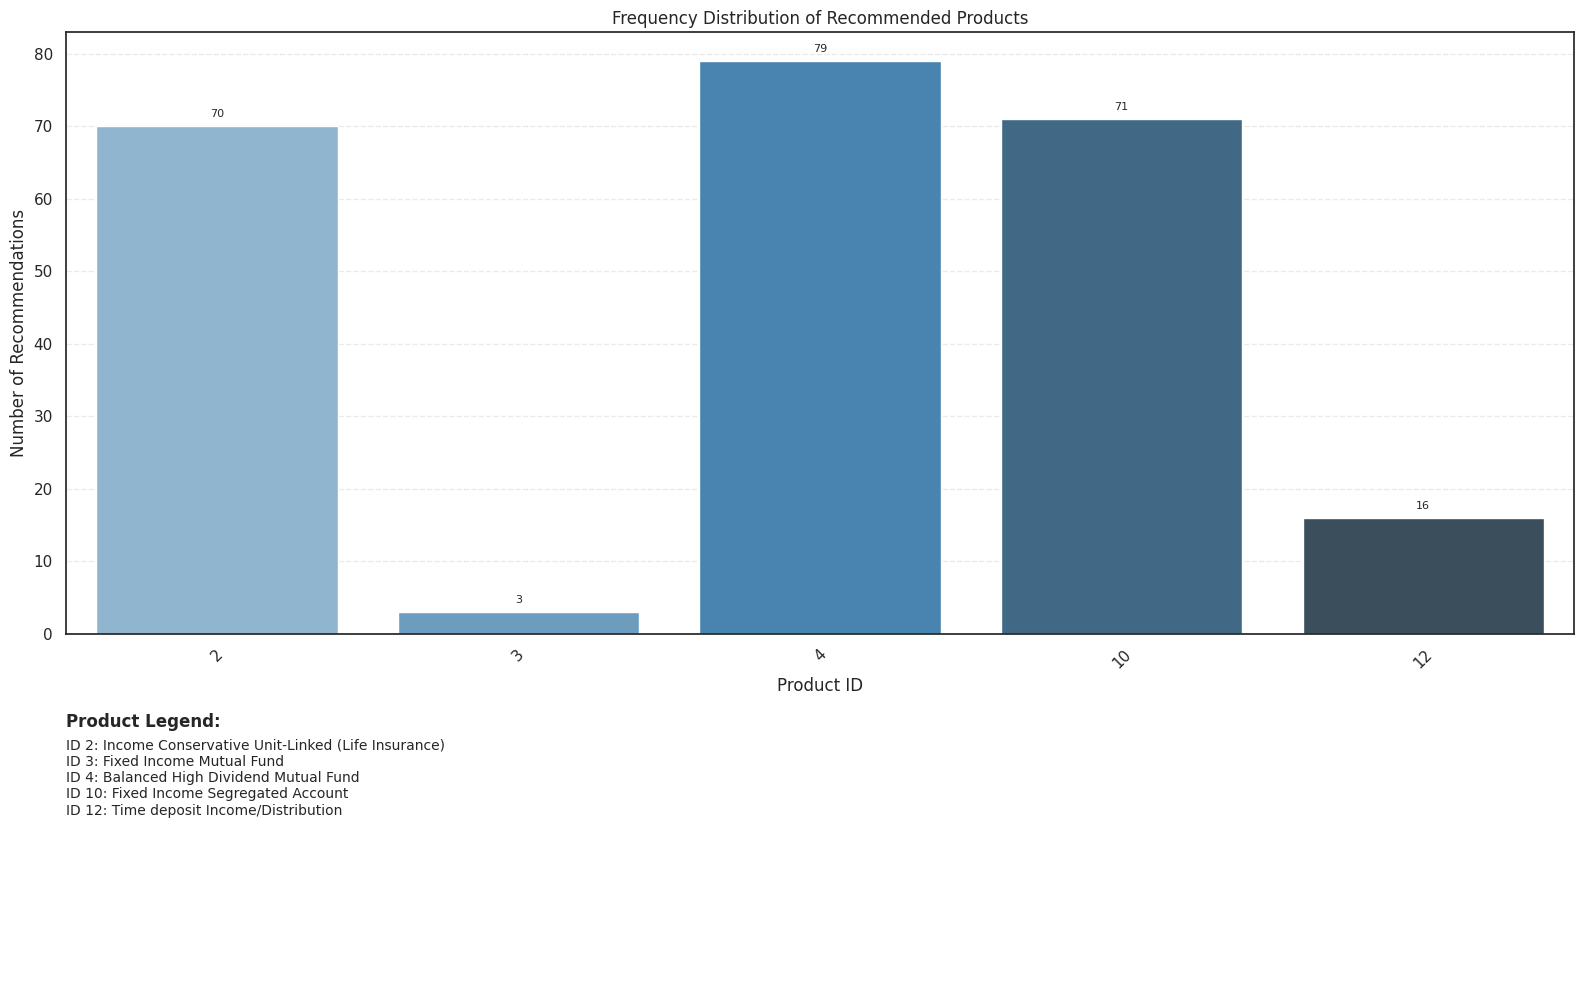

In [ ]:
if clients_with_recommendations > 0:
    recommendation_counts = nba['RecommendedProductID'].value_counts().sort_index()
    recommendation_counts = recommendation_counts[recommendation_counts.index > 0]

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))

    # Main plot
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
    sns.barplot(x=recommendation_counts.index.astype(str),
                y=recommendation_counts.values,
                palette='Blues_d', ax=ax1)
    ax1.set_title('Frequency Distribution of Recommended Products')
    ax1.set_xlabel('Product ID')
    ax1.set_ylabel('Number of Recommendations')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', linestyle='--', alpha=0.4)

    # Add value labels on bars
    for i, val in enumerate(recommendation_counts.values):
        ax1.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=8)

    # Legend subplot
    ax2 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    ax2.axis('off')

    # Create legend text
    legend_items = []
    for pid in recommendation_counts.index:
        if pid in product_legend:
            legend_items.append(f"ID {pid}: {product_legend[pid]}")

    legend_text = "\n".join(legend_items)
    ax2.text(0, 1, "Product Legend:", fontsize=12, fontweight='bold',
             transform=ax2.transAxes, va='top')
    ax2.text(0, 0.9, legend_text, fontsize=10,
             transform=ax2.transAxes, va='top', wrap=True)

    plt.tight_layout()
    plt.show()

<ipython-input-50-b1795f17ae99>:10: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  bars = sns.barplot(y=[f"Product {pid}" for pid in top_5.index],


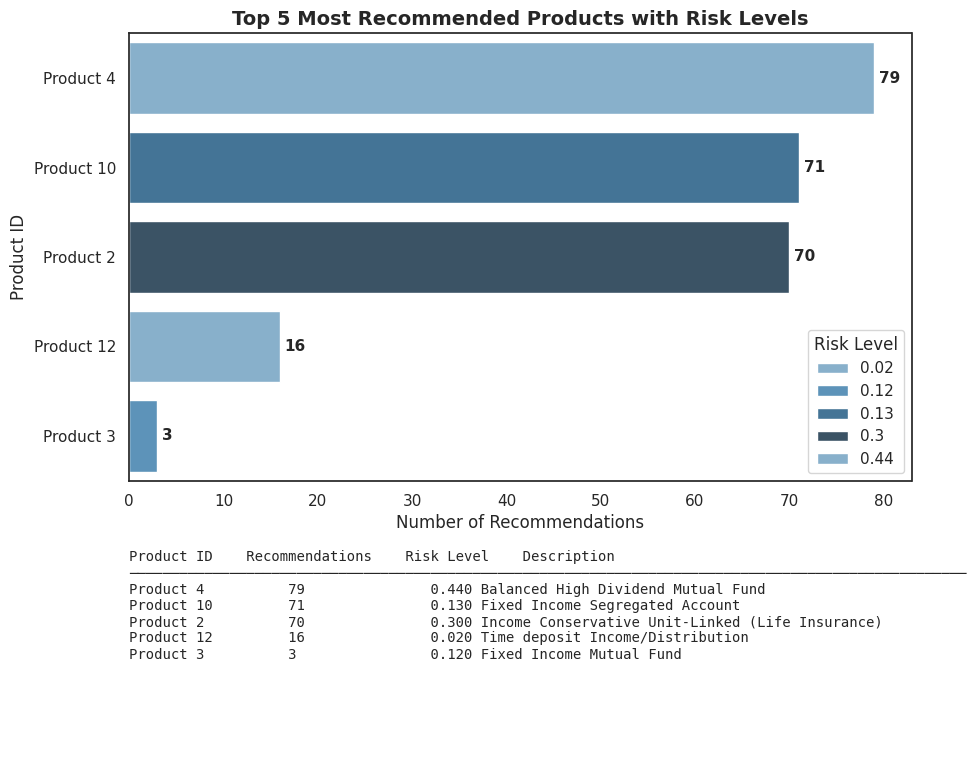

In [ ]:
# Alternative version with better formatting
top_5 = recommendation_counts.nlargest(5)
risks = income_products.set_index('IDProduct').loc[top_5.index, 'Risk']

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),
                               gridspec_kw={'height_ratios': [2, 1]})

# Main plot - use only Product IDs for cleaner display
bars = sns.barplot(y=[f"Product {pid}" for pid in top_5.index],
                  x=top_5.values,
                  hue=risks.values,
                  dodge=False,
                  palette=colors,
                  ax=ax1)

ax1.set_title('Top 5 Most Recommended Products with Risk Levels', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Recommendations')
ax1.set_ylabel('Product ID')
ax1.legend(title='Risk Level', loc='lower right')

# Add recommendation counts as text on the bars
for i, count in enumerate(top_5.values):
    ax1.text(count + 0.5, i, f'{count}', va='center', fontsize=11, fontweight='bold')

# Legend section
ax2.axis('off')

# Create a table-like legend
legend_data = []
for i, pid in enumerate(top_5.index):
    if pid in product_legend:
        count = top_5.iloc[i]
        risk = risks.iloc[i]
        legend_data.append([f"Product {pid}", f"      {count}", f"       {risk:.3f}", product_legend[pid]])

# Create table
table_text = "Product ID    Recommendations    Risk Level    Description\n"
table_text += "─" * 100 + "\n"
for row in legend_data:
    # Truncate description if too long
    desc = row[3][:60] + "..." if len(row[3]) > 60 else row[3]
    table_text += f"{row[0]:<12} {row[1]:<15} {row[2]:<12} {desc}\n"

ax2.text(0, 1, table_text, fontsize=10, fontfamily='monospace',
         transform=ax2.transAxes, va='top')

plt.tight_layout()
plt.show()

In [ ]:
data = {
    'true': y_test_XGB,
    'pred': final_results_XGB['y_test_pred'],
    'Commission': np.zeros(len(y_test_XGB)),
    'Risk': X_base_test_reset['RiskPropensity'].values,
    'Wealth': X_base_test_reset['Wealth_boxcox'].values
}
df_final = pd.DataFrame(data)

# Ensure proper indexing: use the original client indices from X_test
nba_indexed = nba.set_index('ClientID')

# Assign commission fees only to clients in nba
df_final.loc[df_final['pred'] == 1, 'Commission'] = df_final.loc[df_final['pred'] == 1].index.map(nba_indexed['Commission']).fillna(0)

# Compute the mean commission from assigned values (excluding zeros)
mean_commission = np.mean(products_df['Commission'])

# Assign mean commission to all clients who still have 0
df_final.loc[df_final['Commission'] == 0, 'Commission'] = mean_commission



### b) Business Impact Score (BIS) computation

In [ ]:
df_final = reverse_transform(df_final, min_wealth_boxcox, max_wealth_boxcox, min_risk_prop, max_risk_prop )

In [ ]:
def business_oriented_metric(df, alpha, beta):
    # Identify index groups based on conditions
    true_positives = df[(df['true'] == 1) & (df['pred'] == 1)]
    false_negatives = df[(df['true'] == 1) & (df['pred'] == 0)]
    false_positives = df[(df['true'] == 0) & (df['pred'] == 1)]

    # Compute the business-oriented metric
    metric_tp = (true_positives['Commission'] * true_positives['Wealth']).sum()
    metric_fn = (false_negatives['Commission'] * false_negatives['Wealth']).sum()
    metric_fp = (false_positives['Commission'] * false_positives['Wealth']).sum()

    return (metric_tp - alpha * metric_fn - beta * metric_fp)/(df.shape[0])



In [ ]:
# Compute the metric
alpha, beta = 1, 0.1
BIS_XGB = business_oriented_metric(df_final, alpha, beta)
print(f"Business-Oriented Metric Score: {BIS_XGB:.2f}")

Business-Oriented Metric Score: 0.48


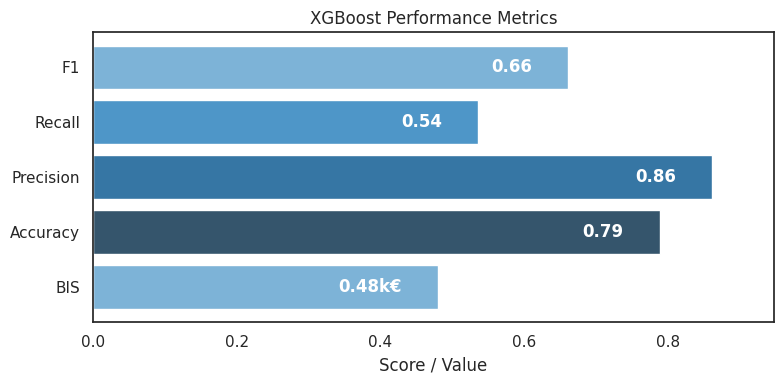

In [ ]:
# Metric values
metric_values_XGB = {
    "F1": final_results_XGB['test_metrics']['f1'],
    "Recall": final_results_XGB['test_metrics']['recall'],
    "Precision": final_results_XGB['test_metrics']['precision'],
    "Accuracy": final_results_XGB['test_metrics']['accuracy'],
    "BIS": BIS_XGB
}

# Extract names and values
names = list(metric_values_XGB.keys())
values = list(metric_values_XGB.values())

# Plot
plt.figure(figsize=(8, 4))
bars = plt.barh(names, values, color=colors)

# Determine dynamic x-axis limit
xmax = max(values) * 1.1
plt.xlim(0, xmax)
plt.xlabel("Score / Value")
plt.title("XGBoost Performance Metrics")

# Add value labels inside bars
for i, (name, v) in enumerate(zip(names, values)):
    if name == "BIS":
        label = f"{v:.2f}k€"
    else:
        label = f"{v:.2f}"
    plt.text(v - 0.05, i, label, va='center', ha='right', color='white', fontweight='bold')

# Invert Y-axis
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



## **10 - Appendix**

## **A - Products recommendation and Results for Baseline Logistic Regression**


### a) Client-product matching based on risk profiles




In [ ]:
# Filtering income products from our product database
income_products = products_df[products_df['Type'] == 0].copy()
min_risk = income_products['Risk'].min() # Will be used for risk matching later

In [ ]:
# Filter for clients predicted to need income products (y_pred == 1)
client_indices = np.where(results_baseline_lr['y_test_pred'] == 1)[0]

# Align indices between X_test and
X_base_test_reset = X_test_lr.reset_index(drop=True)
target_client_ids = X_test_lr.index[client_indices]
target_client_risk_propensity = X_base_test_reset.iloc[client_indices]['RiskPropensity'].values

As motivated above, we added a time-deposit product that allow the bank/asset manager to provide a financial product to the customers with a very low risk propensity

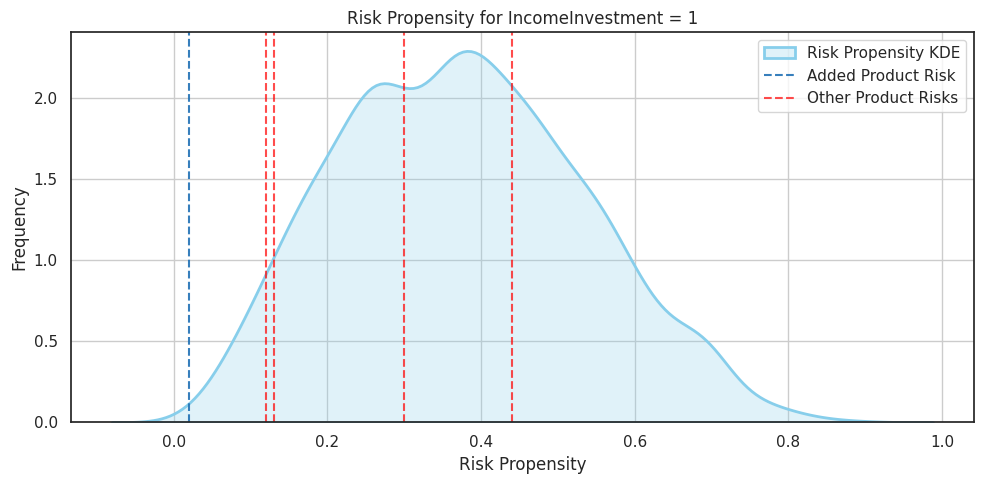

In [ ]:
# Filter the DataFrame
subset_income = scaled_df[scaled_df['IncomeInvestment'] == 1]

# Plot
plt.figure(figsize=(10, 5))
sns.kdeplot(subset_income['RiskPropensity'], color='skyblue', linewidth=2, fill=True, label='Risk Propensity KDE')

plt.title("Risk Propensity for IncomeInvestment = 1")
plt.xlabel("Risk Propensity")
plt.ylabel("Frequency")
plt.grid(True)

# Add vertical lines for Risk values where Type == 0
risk_values = products_df[products_df['Type'] == 0]['Risk'].values

risk_values.sort()

# Plot the first vertical line in a different color (e.g., green)
if len(risk_values) > 0:
    plt.axvline(x=risk_values[0], color='#2171b5', linestyle='--', alpha=0.9, label='Added Product Risk')

# Plot the rest of the lines in red
for risk_value in risk_values[1:]:
    plt.axvline(x=risk_value, color='red', linestyle='--', alpha=0.7, label='Other Product Risks')

# To avoid duplicate legend entries for the red lines
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

In [ ]:

# Initialize lists to store recommendation results
nba_id_product = []
recommended_risk_level = []

# Extract product information for matching
product_ids = income_products['IDProduct'].astype(np.uint16).values
product_risks = income_products['Risk'].values

# Generate personalized recommendations for each target client
for client_risk in target_client_risk_propensity:
    if client_risk > min_risk:
        # Find products with acceptable risk (< customer's appetite)
        suitable_products = product_risks[product_risks < client_risk]

        if len(suitable_products) > 0:
            # Find the product with the highest risk among suitable ones
            max_suitable_risk = max(suitable_products)
            recommended_product_id = product_ids[product_risks == max_suitable_risk][0]
        else:
            recommended_product_id, max_suitable_risk = 0, 0
    else:
        recommended_product_id, max_suitable_risk = 0, 0

    nba_id_product.append(recommended_product_id)
    recommended_risk_level.append(max_suitable_risk)

# Create a recommendation matrix
nba = pd.DataFrame({
    'ClientID': target_client_ids,
    'RecommendedProductID': nba_id_product,
    'ClientRiskPropensity': target_client_risk_propensity,
    'ProductRiskLevel': recommended_risk_level
})


# Step 1: Create a dictionary mapping product IDs to commission fees from products_df
product_fees = dict(zip(products_df['IDProduct'], products_df['Commission']))

# Step 2: Add the commission values to your nba DataFrame first
nba['Commission'] = nba['RecommendedProductID'].map(product_fees).fillna(0)

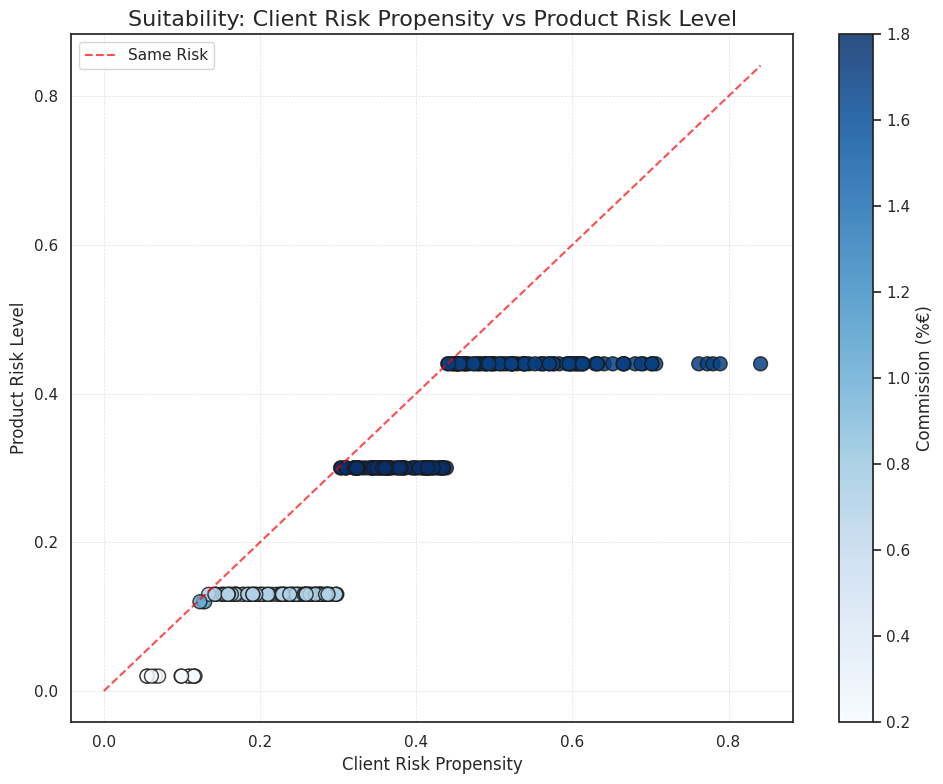

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    nba['ClientRiskPropensity'],
    nba['ProductRiskLevel'],
    c=nba['Commission']*100,
    cmap='Blues',
    edgecolor='k',
    alpha=0.85,
    s=100
)
# Add reference line for perfect risk matching
max_val = max(nba['ClientRiskPropensity'].max(), nba['ProductRiskLevel'].max())
plt.colorbar(scatter, label='Commission (%€)')
plt.plot([0, max_val], [0, max_val], 'red', linestyle='--', alpha=0.7, label='Same Risk')
plt.title('Suitability: Client Risk Propensity vs Product Risk Level', fontsize=16)
plt.xlabel('Client Risk Propensity', fontsize=12)
plt.ylabel('Product Risk Level', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


### b) Analyzing recommendation results


In [ ]:
product_data = metadata_df.iloc[19:33]

# Create the dictionary for a clear legend
product_legend = dict(zip(product_data.iloc[:, 0], product_data.iloc[:, 1]))



Recommendation Statistics:
Total customers requiring an Income product (y_pred = 1): 263
Customers with valid recommendations: 263 (100.0%)
Customers without suitable recommendations: 0 (0.0%)


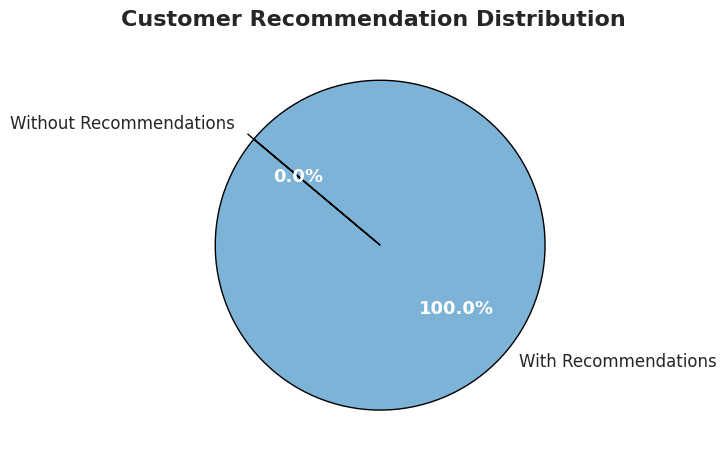

In [ ]:
total_clients = len(nba)
clients_with_recommendations = len(nba[nba['RecommendedProductID'] > 0])
percentage_with_recommendations = (clients_with_recommendations / total_clients) * 100

print("\nRecommendation Statistics:")
print(f"Total customers requiring an Income product (y_pred = 1): {total_clients}")
print(f"Customers with valid recommendations: {clients_with_recommendations} ({percentage_with_recommendations:.1f}%)")
print(f"Customers without suitable recommendations: {total_clients - clients_with_recommendations} ({100-percentage_with_recommendations:.1f}%)")

# Pie chart of recommendation status
labels = ['With Recommendations', 'Without Recommendations']
sizes = [clients_with_recommendations, total_clients - clients_with_recommendations]
colors = colors
explode = (0.05, 0)

plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors,
                                   autopct='%1.1f%%', startangle=140,
                                   explode=explode, wedgeprops={'edgecolor': 'black'},
                                   textprops={'fontsize': 12})

plt.setp(autotexts, size=13, weight="bold", color='white')
plt.setp(texts, size=12)

plt.title('Customer Recommendation Distribution', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()



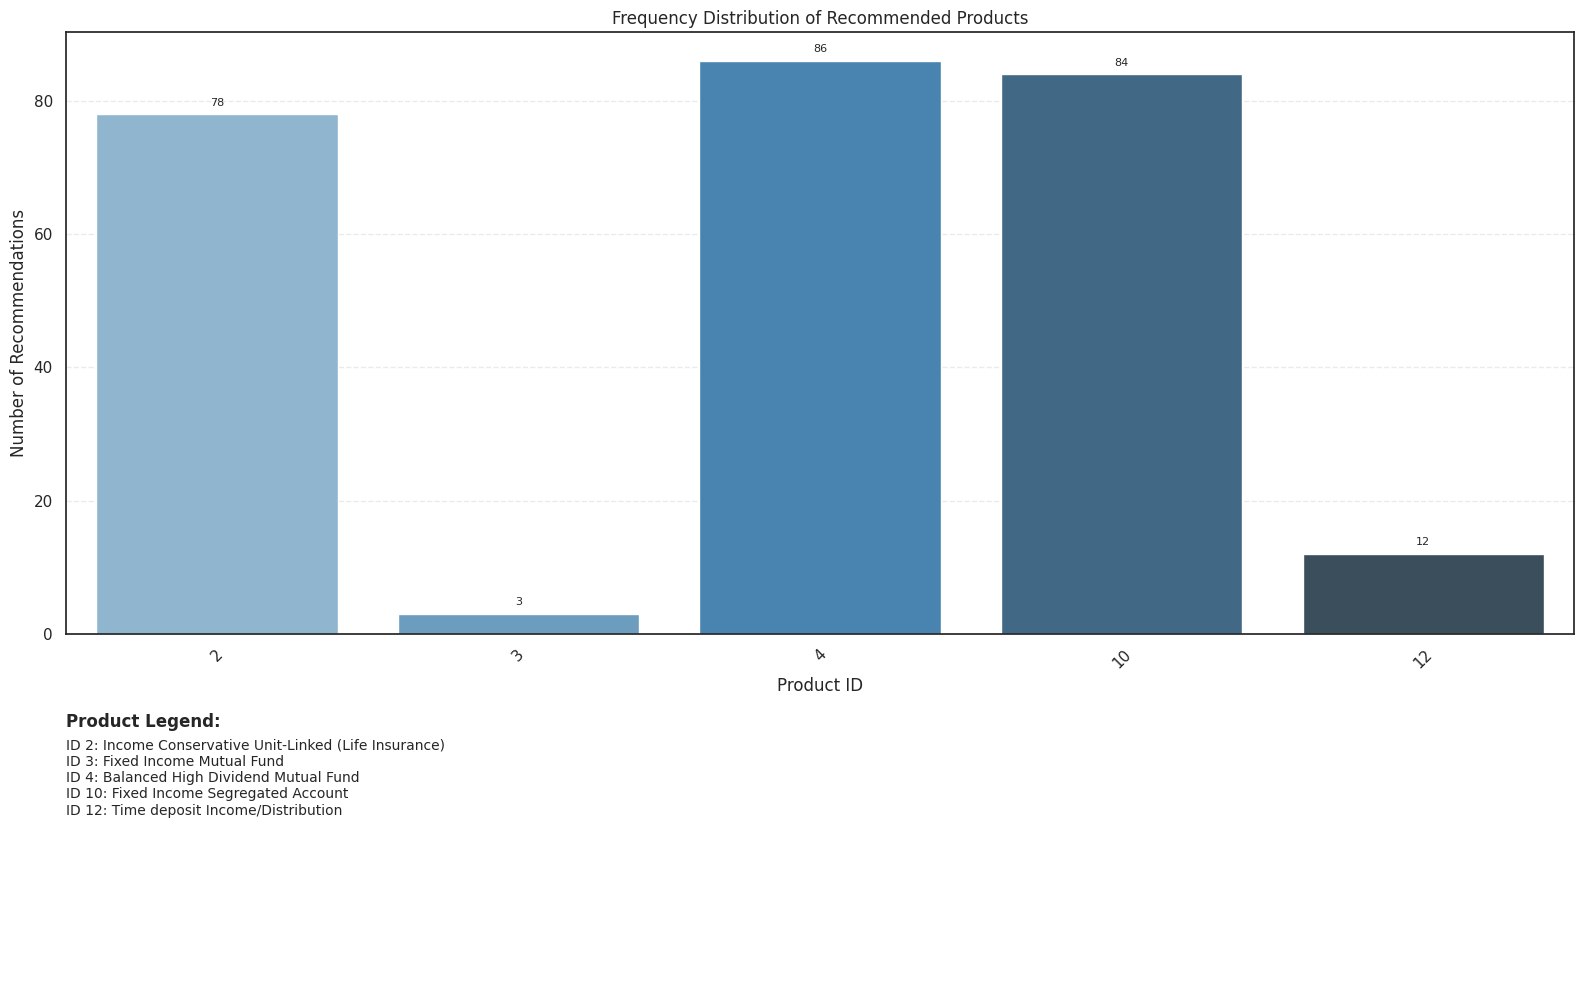

In [ ]:
# Create a figure with main plot and legend subplot
if clients_with_recommendations > 0:
    recommendation_counts = nba['RecommendedProductID'].value_counts().sort_index()
    recommendation_counts = recommendation_counts[recommendation_counts.index > 0]

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))

    # Main plot
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
    sns.barplot(x=recommendation_counts.index.astype(str),
                y=recommendation_counts.values,
                palette='Blues_d', ax=ax1)
    ax1.set_title('Frequency Distribution of Recommended Products')
    ax1.set_xlabel('Product ID')
    ax1.set_ylabel('Number of Recommendations')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', linestyle='--', alpha=0.4)

    # Add value labels on bars
    for i, val in enumerate(recommendation_counts.values):
        ax1.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=8)

    # Legend subplot
    ax2 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    ax2.axis('off')

    # Create legend text
    legend_items = []
    for pid in recommendation_counts.index:
        if pid in product_legend:
            legend_items.append(f"ID {pid}: {product_legend[pid]}")

    legend_text = "\n".join(legend_items)
    ax2.text(0, 1, "Product Legend:", fontsize=12, fontweight='bold',
             transform=ax2.transAxes, va='top')
    ax2.text(0, 0.9, legend_text, fontsize=10,
             transform=ax2.transAxes, va='top', wrap=True)

    plt.tight_layout()
    plt.show()

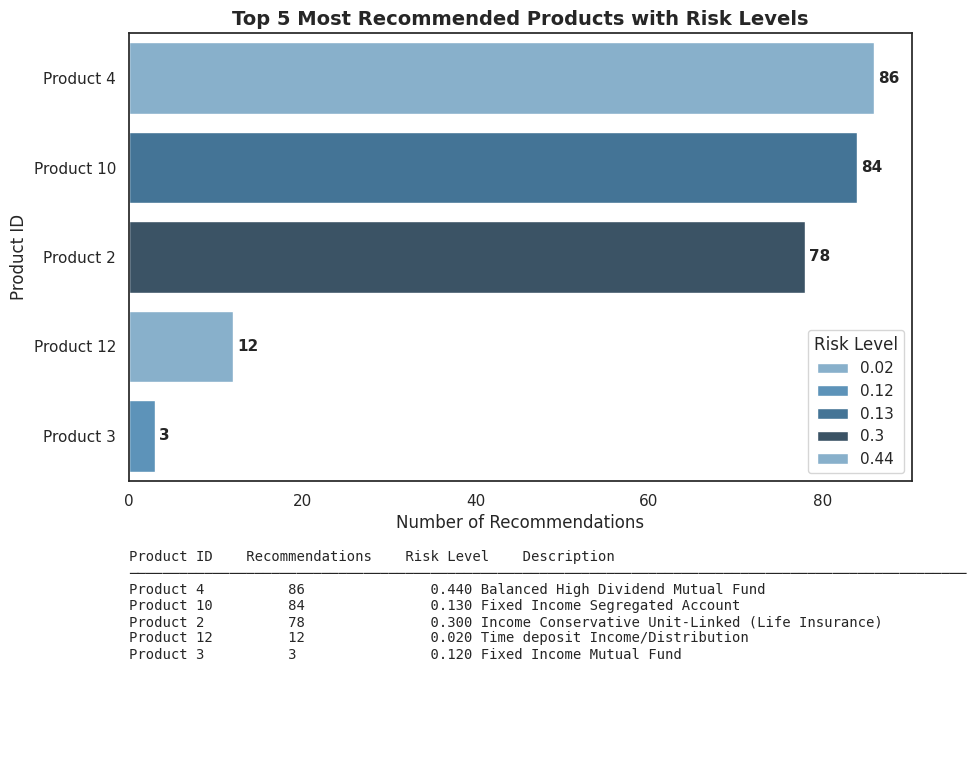

In [ ]:
# Alternative version with better formatting
top_5 = recommendation_counts.nlargest(5)
risks = income_products.set_index('IDProduct').loc[top_5.index, 'Risk']

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),
                               gridspec_kw={'height_ratios': [2, 1]})

# Main plot - use only Product IDs for cleaner display
bars = sns.barplot(y=[f"Product {pid}" for pid in top_5.index],
                  x=top_5.values,
                  hue=risks.values,
                  dodge=False,
                  palette=colors,
                  ax=ax1)

ax1.set_title('Top 5 Most Recommended Products with Risk Levels', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Recommendations')
ax1.set_ylabel('Product ID')
ax1.legend(title='Risk Level', loc='lower right')

# Add recommendation counts as text on the bars
for i, count in enumerate(top_5.values):
    ax1.text(count + 0.5, i, f'{count}', va='center', fontsize=11, fontweight='bold')

# Legend section
ax2.axis('off')

# Create a table-like legend
legend_data = []
for i, pid in enumerate(top_5.index):
    if pid in product_legend:
        count = top_5.iloc[i]
        risk = risks.iloc[i]
        legend_data.append([f"Product {pid}", f"      {count}", f"       {risk:.3f}", product_legend[pid]])

# Create table
table_text = "Product ID    Recommendations    Risk Level    Description\n"
table_text += "─" * 100 + "\n"
for row in legend_data:
    # Truncate description if too long
    desc = row[3][:60] + "..." if len(row[3]) > 60 else row[3]
    table_text += f"{row[0]:<12} {row[1]:<15} {row[2]:<12} {desc}\n"

ax2.text(0, 1, table_text, fontsize=10, fontfamily='monospace',
         transform=ax2.transAxes, va='top')

plt.tight_layout()
plt.show()

In [ ]:
data = {
    'true': y_test_lr,
    'pred': results_baseline_lr['y_test_pred'],
    'Commission': np.zeros(len(y_test_lr)),
    'Risk': X_base_test_reset['RiskPropensity'].values,
    'Wealth': X_base_test_reset['Wealth_boxcox'].values
}
df_final = pd.DataFrame(data)

# Ensure proper indexing: use the original client indices from X_test
nba_indexed = nba.set_index('ClientID')

# Assign commission fees only to clients in nba
df_final.loc[df_final['pred'] == 1, 'Commission'] = df_final.loc[df_final['pred'] == 1].index.map(nba_indexed['Commission']).fillna(0)

# Compute the mean commission from assigned values (excluding zeros)
mean_commission = np.mean(products_df['Commission'])

# Assign mean commission to all clients who still have 0
df_final.loc[df_final['Commission'] == 0, 'Commission'] = mean_commission



In [ ]:
df_final = reverse_transform(df_final, min_wealth_boxcox, max_wealth_boxcox, min_risk_prop, max_risk_prop )

In [ ]:
# Compute the metric
alpha, beta = 1, 0.1
BIS_lr = business_oriented_metric(df_final, alpha, beta)
print(f"Business-Oriented Metric Score: {BIS_lr:.2f}")

Business-Oriented Metric Score: 0.46


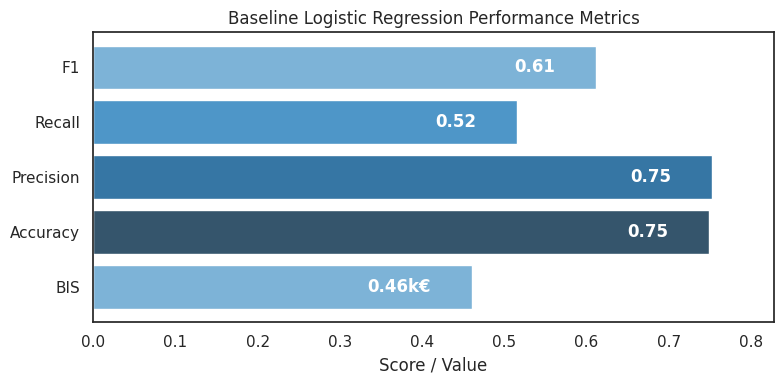

In [ ]:
# Metrics excluding 'Info'
metric_values_lr = {
    "F1": results_baseline_lr['test_metrics']['f1'],
    "Recall": results_baseline_lr['test_metrics']['recall'],
    "Precision": results_baseline_lr['test_metrics']['precision'],
    "Accuracy": results_baseline_lr['test_metrics']['accuracy'],
    "BIS": BIS_lr
}

# Extract names and values
names = list(metric_values_lr.keys())
values = list(metric_values_lr.values())

# Plot
plt.figure(figsize=(8, 4))
plt.barh(names, values, color=colors)

# Determine dynamic x-axis limit
xmax = max(values) * 1.1
plt.xlim(0, xmax)
plt.xlabel("Score / Value")
plt.title("Baseline Logistic Regression Performance Metrics")

# Add value labels inside bars
for i, (name, v) in enumerate(zip(names, values)):
    if name == "BIS":
        label = f"{v:.2f}k€"
    else:
        label = f"{v:.2f}"
    plt.text(v - 0.05, i, label, va='center', ha='right', color='white', fontweight='bold')

# Invert Y-axis
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



## **B - Further Feature Engineering study**
Since the initial feature transformations did not yield a significant improvement in our primary metric (F1 score), we conducted a more in-depth analysis by exploring additional transformations and feature combinations. The following hidden cells document these further attempts, which ultimately did not lead to a successful enhancement of the model's performance.

Warning: Running these cells may take a considerable amount of time.

In [ ]:
from itertools import combinations

# Max number of candidate features to add
max_k = 2
# Max number of baseline features to exclude
max_drop = 2

all_results = []

# Define models
models = {
    'Logistic_regression': LogisticRegression(),
}


for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    print("=" * 80)

    # Original baseline score
    X_train_base = X_train_lr_eng[baseline_features_lr]
    X_test_base = X_test_lr_eng[baseline_features_lr]
    results_base = train_evaluate_model(X_train_base, y_train_lr_eng, X_test_base, y_test_lr_eng, model)
    display_results_table(results_base, model_name, "Base Features")

    # Loop over baseline subsets (removing up to `max_drop` features)
    for num_drops in range(0, max_drop + 1):
        for drops in combinations(baseline_features_lr, num_drops):
            reduced_baseline = [f for f in baseline_features_lr if f not in drops]

            # Now try adding up to `max_k` candidate features
            for k in range(0, max_k + 1):
                for added in combinations(candidate_features_lr, k):
                    current_features = reduced_baseline + list(added)

                    X_train_current = X_train_lr_eng[current_features]
                    X_test_current = X_test_lr_eng[current_features]
                    result = train_evaluate_model(X_train_current,  y_train_lr_eng, X_test_current,  y_test_lr_eng, model)

                    # Description string
                    drop_str = f" - {' - '.join(drops)}" if drops else ""
                    add_str = f" + {' + '.join(added)}" if added else ""
                    display_name = f"Base{drop_str}{add_str}"

                    display_results_table(result, model_name, display_name)

Output streaming troncato alle ultime 5000 righe.
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.774  | 0.017  |  0.756   |
| 1 | Precision |  0.789  | 0.022  |  0.776   |
| 2 |  Recall   |  0.563  | 0.037  |  0.513   |
| 3 |    F1     |  0.656  | 0.027  |  0.618   |
+---+-----------+---------+--------+----------+

Logistic_regression - Base - Age - Gender + Income_Wealth_ratio + High_wealth
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.735  | 0.009  |  0.714   |
| 1 | Precision |  0.826  | 0.028  |  0.778   |
| 2 |  Recall   |  0.394  | 0.016  |  0.357   |
| 3 |    F1     |  0.533  |  0.01  |  0.489   |
+---+-----------+---------+--------+----------+

Logistic_regression - Base - Age - Gender + Income_Wealth_ratio + RiskPropensity_Wealth
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+---------

In [ ]:
def create_features(df, degree=2, include_bias=False):
    """
    Creates engineered features from the raw data, including polynomial features.

    Args:
        df (pd.DataFrame): The main DataFrame (e.g., needs_df).
        products_df (pd.DataFrame): The products DataFrame.
        metadata_df (pd.DataFrame): The metadata DataFrame.
        degree (int): The degree of the polynomial features.
        include_bias (bool): Whether to include a bias (constant) term in the polynomial features.

    Returns:
        pd.DataFrame: The DataFrame with engineered and polynomial features added.
    """

    # Make a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Ensure Wealth and Income are positive before Box-Cox
    wealth_min = df['Wealth'].min()
    income_min = df['Income '].min()

    wealth_shift = 0 if wealth_min > 0 else abs(wealth_min) + 1
    income_shift = 0 if income_min > 0 else abs(income_min) + 1

    df['Wealth'] = df['Wealth'] + wealth_shift
    df['Income '] = df['Income '] + income_shift

    # Apply Box-Cox transformation
    df['Wealth_boxcox'], _ = boxcox(df['Wealth'])  # Store lambda if needed
    df['Income_boxcox'], _ = boxcox(df['Income ']) # Store lambda if needed

    # Basic ratios
    df["Income_Wealth_ratio"] = df["Income "] / df["Wealth"]

    #Interaction terms
    df["RiskPropensity_Wealth"] = df["RiskPropensity"] * df["Wealth"]
    df["RiskPropensity_Income"] = df["RiskPropensity"] * df["Income "]


    # --- Polynomial Feature Generation ---
    # Select numerical features for polynomial transformation
    numerical_features = ['Age', 'FamilyMembers', 'Wealth_boxcox', 'Income_boxcox', 'RiskPropensity', 'FinancialEducation']
    numerical_data = df[numerical_features]

    # Initialize PolynomialFeatures transformer
    poly = PolynomialFeatures(degree=degree, include_bias=include_bias)

    # Fit and transform the data
    poly_features = poly.fit_transform(numerical_data)

    # Create a DataFrame for the polynomial features
    poly_feature_names = [f"poly_{i}" for i in range(poly_features.shape[1])]  # Generic names
    poly_df = pd.DataFrame(poly_features, index=df.index, columns=poly_feature_names)

    # Concatenate polynomial features with the original DataFrame
    df = pd.concat([df, poly_df], axis=1)

    return df

In [ ]:
# Assuming needs_df are already loaded
feature_engineering_df2 = feature_engineering_df.copy()
feature_engineering_df2 = create_features(feature_engineering_df2, degree=2, include_bias=False)

In [ ]:
# Define the variables you do not want to scale
vars_not_to_normalize = ['Gender', 'High_Income', 'High_Wealth']

# Infer the variables that should be scaled
vars_to_normalize = [col for col in feature_engineering_df2.columns if col not in vars_not_to_normalize]

# Apply MinMaxScaler to the selected variables
scaler = MinMaxScaler()
feature_engineering_df2[vars_to_normalize] = scaler.fit_transform(feature_engineering_df2[vars_to_normalize])

In [ ]:
# Data split
X_train_eng_lr2, X_test_eng_lr2, y_train_eng_lr2, y_test_eng_lr2 = train_test_split(feature_engineering_df2.drop(['IncomeInvestment', 'AccumulationInvestment'], axis = 1), y, test_size=0.2, random_state=seed, stratify=y)

In [ ]:
# Define baseline features
baseline_features_lr2 = [
    'Age', 'FamilyMembers', 'FinancialEducation',
    'RiskPropensity',
    'Wealth_boxcox', 'Income_boxcox'
]

# Define excluded features
excluded_features_lr2 = {'Wealth_log', 'Income_log', 'Income ', 'Wealth', 'IncomeInvestment', 'AccumulationInvestment','Gender', 'Gender_Wealth', 'Gender_Income'}

# Features to test one by one
candidate_features_lr2 = [
    f for f in feature_engineering_df2.columns
    if f not in baseline_features_lr2 and f not in excluded_features_lr2
]

# Define models
models = {
    'Logistic_regression': LogisticRegression(),
}

target_name = "Accumulation Investment"

print(f"\nTarget Variable: {target_name}")
print("=" * 80)
X_train_eng_lr2, X_test_eng_lr2, y_train_eng_lr2, y_test_eng_lr2
# Loop over models
for model_name, model in models.items():
    # Baseline features
    X_train_base = X_train_eng_lr2[baseline_features_lr2]
    X_test_base = X_test_eng_lr2[baseline_features_lr2]
    results_base = train_evaluate_model(X_train_base, y_train_eng_lr2, X_test_base, y_test_eng_lr2, model)
    display_results_table(results_base, model_name, "Base Features")

    # Test each additional feature
    for extra_feature in candidate_features_lr2:
        features = baseline_features_lr2 + [extra_feature]
        X_train_feat = X_train_eng_lr2[features]
        X_test_feat = X_test_eng_lr2[features]

        result_baseline_lr2 = train_evaluate_model(X_train_feat, y_train_eng_lr2, X_test_feat, y_test_eng_lr2, model)
        display_results_table(result_baseline_lr2, model_name, f"Base + {extra_feature}")




Target Variable: Accumulation Investment

Logistic_regression - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.774  | 0.011  |  0.746   |
| 1 | Precision |  0.781  | 0.012  |  0.743   |
| 2 |  Recall   |  0.573  | 0.036  |  0.518   |
| 3 |    F1     |  0.66   | 0.019  |   0.61   |
+---+-----------+---------+--------+----------+

Logistic_regression - Base + Income_Wealth_ratio
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.774  | 0.011  |  0.746   |
| 1 | Precision |  0.779  | 0.011  |  0.743   |
| 2 |  Recall   |  0.573  | 0.036  |  0.518   |
| 3 |    F1     |  0.659  | 0.019  |   0.61   |
+---+-----------+---------+--------+----------+

Logistic_regression - Base + High_income
+---+-----------+---------+--------+----------+
|   |  Metric

## **C - XGBoost optimization**

In [ ]:
import itertools
from itertools import product

In [ ]:
XGB_eng_df = feature_engineering_df.copy()

# Baseline features
baseline_features_XGB = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Wealth_boxcox', 'Income_boxcox']

# Define excluded features
excluded_features_XGB = {'Wealth_log', 'Income_log', 'Income ', 'Wealth', 'IncomeInvestment', 'AccumulationInvestment'}

# Features to test one by one
candidate_features_XGB = [f for f in XGB_eng_df.columns if f not in baseline_features_XGB and f not in excluded_features_XGB]

xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=seed,
    learning_rate= 0.05,
    max_depth= 4,
    n_estimators= 100
)

# Define models
models = {
    'XGBoost': xgb_model
}

# Data split
X_train_XGB_eng, X_test_XGB_eng, y_train_XGB_eng, y_test_XGB_eng = train_test_split(XGB_eng_df, y, test_size=0.2, random_state=seed, stratify=y)

target_name = "Income Investment"

print(f"\nTarget Variable: {target_name}")
print("=" * 80)
# Loop over models
for model_name, model in models.items():
    # Baseline features
    X_train_base = X_train_XGB_eng[baseline_features_XGB]
    X_test_base = X_test_XGB_eng[baseline_features_XGB]
    results_base = train_evaluate_model(X_train_base, y_train_XGB_eng, X_test_base, y_test_XGB_eng, model)
    display_results_table(results_base, model_name, "Base Features")

    # Loop over all combinations of candidate features (1 to all)
    for k in range(1, len(candidate_features_XGB) + 1):
      for combo in itertools.combinations(candidate_features_XGB, k):
            combo_features = baseline_features_XGB + list(combo)
            X_train_combo = X_train_XGB_eng[combo_features]
            X_test_combo = X_test_XGB_eng[combo_features]

            name = "Base + [" + ", ".join(combo) + "]"
            result_XGB_eng = train_evaluate_model(X_train_combo, y_train_XGB_eng, X_test_combo, y_test_XGB_eng, model)
            display_results_table(result_XGB_eng, model_name, name)


Target Variable: Income Investment

XGBoost - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.818  |  0.01  |   0.78   |
| 1 | Precision |  0.869  | 0.014  |  0.828   |
| 2 |  Recall   |  0.618  | 0.025  |  0.539   |
| 3 |    F1     |  0.722  | 0.015  |  0.653   |
+---+-----------+---------+--------+----------+

XGBoost - Base + [Income_Wealth_ratio]
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.829  |  0.01  |  0.787   |
| 1 | Precision |  0.904  | 0.012  |  0.858   |
| 2 |  Recall   |  0.621  | 0.027  |  0.534   |
| 3 |    F1     |  0.736  | 0.018  |  0.658   |
+---+-----------+---------+--------+----------+

XGBoost - Base + [High_income]
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+--

From the output of the previous cell, the main and only driver for the the improvement of the performances seems to be the Income / Wealth ratio

In [ ]:
# Best combination of features
best_combination_XGB = ['Income_Wealth_ratio']

# Select best feature combination
best_features_XGB = baseline_features_XGB + list(best_combination_XGB)

X_train_best = X_train_XGB_eng[best_features_XGB]
X_test_best = X_test_XGB_eng[best_features_XGB]

In [ ]:
# After so attempts of grid search and manually refining it, we finally find the
# following parameter grid, which allow to find the best combination of parameters
param_grid_XGB = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 5, 7]
}

# Generate all combinations of hyperparameters
param_combinations_XGB = list(product(
    param_grid_XGB['n_estimators'],
    param_grid_XGB['learning_rate'],
    param_grid_XGB['max_depth']
))

# Store results
results_XGB = []

best_f1 = -1
best_params = None
best_result = None

for n_estimators, learning_rate, max_depth in param_combinations_XGB:
    # Define model with current parameters
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        eval_metric='logloss',
        random_state=seed
    )

    # Train and evaluate model
    result = train_evaluate_model(X_train_best, y_train_XGB_eng, X_test_best, y_test_XGB_eng, model)

    mean_cv_f1 = result['cv_metrics']['f1']['mean']
    test_f1 = result['test_metrics']['f1']

    # Save results
    results_XGB.append({
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'cv_f1': mean_cv_f1,
        'test_f1': test_f1
    })

    # Update best
    if mean_cv_f1 > best_f1:
        best_f1 = mean_cv_f1
        best_params = {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth
        }
        best_result = result

# Convert to DataFrame for inspection
results_df = pd.DataFrame(results_XGB).sort_values(by='cv_f1', ascending=False)

# Display best
print("Best Hyperparameters (based on CV F1):", best_params)
display_results_table(best_result, "XGBoost", "Best Features and Custom Grid Search")

Best Hyperparameters (based on CV F1): {'n_estimators': 200, 'learning_rate': 0.03, 'max_depth': 5}

XGBoost - Best Features and Custom Grid Search
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.83   | 0.011  |  0.789   |
| 1 | Precision |  0.899  | 0.014  |  0.862   |
| 2 |  Recall   |  0.626  | 0.029  |  0.536   |
| 3 |    F1     |  0.737  | 0.021  |  0.661   |
+---+-----------+---------+--------+----------+


## **D - Neural Network optimization**

In [ ]:
!pip install optuna
import optuna

In [ ]:
# Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    hidden_layers = trial.suggest_int('hidden_layers', 1, 3)
    hidden_units = trial.suggest_int('hidden_units', 32, 256)
    dropout = trial.suggest_float('dropout', 0.05, 0.3)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Create training and validation dataset
    X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_val_nn, y_train_val_nn, test_size=0.2, random_state=seed, stratify=y_train_val_nn)

    # Creating data loader
    train_dataset_nn_optuna = InvestmentDataset(X_train_nn, y_train_nn)
    val_dataset_nn_optuna = InvestmentDataset(X_val_nn, y_val_nn)
    train_loader = DataLoader(train_dataset_nn_optuna, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset_nn_optuna, batch_size=batch_size, shuffle=False)

    # Compute class weights for BCEWithLogitsLoss
    num_pos = np.sum(y_train_nn)
    num_neg = len(y_train_nn) - num_pos
    pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32)

    # Initialize model
    model = MLP(input_size=X_train_nn.shape[1], hidden_layers=hidden_layers, hidden_units=hidden_units, dropout=dropout)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Train model
    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

    # Evaluate performance
    test_metrics, _, _ = evaluate_nn_metrics(model, val_loader)

    # Optimize F1-score
    return test_metrics['f1']


In [ ]:
# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

# Get best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-05-30 15:50:49,278] A new study created in memory with name: no-name-963ebdf0-1558-45c7-a91a-9afbcf86b57d
<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7270, Val Loss: 0.7056, Val Accuracy: 0.7212
Epoch 20, Train Loss: 0.7080, Val Loss: 0.6904, Val Accuracy: 0.7250
Epoch 30, Train Loss: 0.6823, Val Loss: 0.6829, Val Accuracy: 0.7362
Epoch 40, Train Loss: 0.6805, Val Loss: 0.6776, Val Accuracy: 0.7500
Epoch 50, Train Loss: 0.6797, Val Loss: 0.6729, Val Accuracy: 0.7438
Epoch 60, Train Loss: 0.6686, Val Loss: 0.6702, Val Accuracy: 0.7525
Epoch 70, Train Loss: 0.6692, Val Loss: 0.6700, Val Accuracy: 0.7638
Epoch 80, Train Loss: 0.6721, Val Loss: 0.6695, Val Accuracy: 0.7462
Epoch 90, Train Loss: 0.6544, Val Loss: 0.6676, Val Accuracy: 0.7538


[I 2025-05-30 15:51:04,633] Trial 0 finished with value: 0.6666666666666666 and parameters: {'hidden_layers': 1, 'hidden_units': 187, 'dropout': 0.14402291916569054, 'lr': 0.00011888620186448227, 'batch_size': 64}. Best is trial 0 with value: 0.6666666666666666.


Epoch 100, Train Loss: 0.6552, Val Loss: 0.6674, Val Accuracy: 0.7562


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7367, Val Loss: 0.7016, Val Accuracy: 0.7225
Epoch 20, Train Loss: 0.6932, Val Loss: 0.6873, Val Accuracy: 0.7350
Epoch 30, Train Loss: 0.6795, Val Loss: 0.6846, Val Accuracy: 0.7525
Epoch 40, Train Loss: 0.6656, Val Loss: 0.6838, Val Accuracy: 0.7550
Epoch 50, Train Loss: 0.6597, Val Loss: 0.6839, Val Accuracy: 0.7488
Epoch 60, Train Loss: 0.6618, Val Loss: 0.6830, Val Accuracy: 0.7512
Epoch 70, Train Loss: 0.6586, Val Loss: 0.6834, Val Accuracy: 0.7562


[I 2025-05-30 15:51:18,082] Trial 1 finished with value: 0.6516464471403813 and parameters: {'hidden_layers': 2, 'hidden_units': 143, 'dropout': 0.09721112525614041, 'lr': 7.188010636103269e-05, 'batch_size': 64}. Best is trial 0 with value: 0.6666666666666666.


Early stopping at epoch 75


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7135, Val Loss: 0.6849, Val Accuracy: 0.7675
Epoch 20, Train Loss: 0.6952, Val Loss: 0.6786, Val Accuracy: 0.7575
Epoch 30, Train Loss: 0.6765, Val Loss: 0.6755, Val Accuracy: 0.7650


[I 2025-05-30 15:51:32,800] Trial 2 finished with value: 0.6567717996289425 and parameters: {'hidden_layers': 3, 'hidden_units': 181, 'dropout': 0.22057847387142093, 'lr': 0.000161319791971469, 'batch_size': 32}. Best is trial 0 with value: 0.6666666666666666.


Early stopping at epoch 36


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7048, Val Loss: 0.6856, Val Accuracy: 0.7500
Epoch 20, Train Loss: 0.6890, Val Loss: 0.6833, Val Accuracy: 0.7588
Epoch 30, Train Loss: 0.6696, Val Loss: 0.6795, Val Accuracy: 0.7675
Epoch 40, Train Loss: 0.6669, Val Loss: 0.6771, Val Accuracy: 0.7688
Epoch 50, Train Loss: 0.6638, Val Loss: 0.6799, Val Accuracy: 0.7638
Epoch 60, Train Loss: 0.6543, Val Loss: 0.6747, Val Accuracy: 0.7662
Epoch 70, Train Loss: 0.6518, Val Loss: 0.6758, Val Accuracy: 0.7675
Epoch 80, Train Loss: 0.6439, Val Loss: 0.6733, Val Accuracy: 0.7688
Epoch 90, Train Loss: 0.6340, Val Loss: 0.6745, Val Accuracy: 0.7612


[I 2025-05-30 15:52:01,677] Trial 3 finished with value: 0.6570397111913358 and parameters: {'hidden_layers': 2, 'hidden_units': 189, 'dropout': 0.19354093601472983, 'lr': 0.00017937344691709156, 'batch_size': 32}. Best is trial 0 with value: 0.6666666666666666.


Early stopping at epoch 91


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7203, Val Loss: 0.6763, Val Accuracy: 0.7625
Epoch 20, Train Loss: 0.7159, Val Loss: 0.6788, Val Accuracy: 0.7700
Epoch 30, Train Loss: 0.6931, Val Loss: 0.6752, Val Accuracy: 0.7625
Epoch 40, Train Loss: 0.6932, Val Loss: 0.6764, Val Accuracy: 0.7650
Epoch 50, Train Loss: 0.6848, Val Loss: 0.6792, Val Accuracy: 0.7712


[I 2025-05-30 15:52:30,871] Trial 4 finished with value: 0.6678765880217786 and parameters: {'hidden_layers': 2, 'hidden_units': 139, 'dropout': 0.17876631932968612, 'lr': 0.00010906678983533374, 'batch_size': 16}. Best is trial 4 with value: 0.6678765880217786.


Early stopping at epoch 54


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7148, Val Loss: 0.6957, Val Accuracy: 0.7525
Epoch 20, Train Loss: 0.6799, Val Loss: 0.6824, Val Accuracy: 0.7475
Epoch 30, Train Loss: 0.6693, Val Loss: 0.6772, Val Accuracy: 0.7488
Epoch 40, Train Loss: 0.6606, Val Loss: 0.6745, Val Accuracy: 0.7662
Epoch 50, Train Loss: 0.6683, Val Loss: 0.6753, Val Accuracy: 0.7688
Epoch 60, Train Loss: 0.6544, Val Loss: 0.6733, Val Accuracy: 0.7662
Epoch 70, Train Loss: 0.6488, Val Loss: 0.6709, Val Accuracy: 0.7688
Epoch 80, Train Loss: 0.6514, Val Loss: 0.6722, Val Accuracy: 0.7688


[I 2025-05-30 15:52:46,083] Trial 5 finished with value: 0.672566371681416 and parameters: {'hidden_layers': 2, 'hidden_units': 122, 'dropout': 0.08779705194530783, 'lr': 9.333047869079767e-05, 'batch_size': 64}. Best is trial 5 with value: 0.672566371681416.


Early stopping at epoch 89


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7563, Val Loss: 0.7372, Val Accuracy: 0.6787
Epoch 20, Train Loss: 0.7048, Val Loss: 0.7013, Val Accuracy: 0.7350
Epoch 30, Train Loss: 0.6995, Val Loss: 0.6892, Val Accuracy: 0.7438
Epoch 40, Train Loss: 0.6749, Val Loss: 0.6807, Val Accuracy: 0.7550
Epoch 50, Train Loss: 0.6782, Val Loss: 0.6783, Val Accuracy: 0.7575
Epoch 60, Train Loss: 0.6693, Val Loss: 0.6769, Val Accuracy: 0.7600
Epoch 70, Train Loss: 0.6595, Val Loss: 0.6767, Val Accuracy: 0.7600
Epoch 80, Train Loss: 0.6566, Val Loss: 0.6743, Val Accuracy: 0.7575
Epoch 90, Train Loss: 0.6571, Val Loss: 0.6727, Val Accuracy: 0.7550


[I 2025-05-30 15:53:01,588] Trial 6 finished with value: 0.6619718309859155 and parameters: {'hidden_layers': 2, 'hidden_units': 50, 'dropout': 0.06993017975492076, 'lr': 0.00011010452220262126, 'batch_size': 64}. Best is trial 5 with value: 0.672566371681416.


Epoch 100, Train Loss: 0.6568, Val Loss: 0.6730, Val Accuracy: 0.7600


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.9001, Val Loss: 0.8463, Val Accuracy: 0.5800
Epoch 20, Train Loss: 0.8375, Val Loss: 0.7900, Val Accuracy: 0.6312
Epoch 30, Train Loss: 0.7923, Val Loss: 0.7578, Val Accuracy: 0.6550
Epoch 40, Train Loss: 0.7662, Val Loss: 0.7400, Val Accuracy: 0.6850
Epoch 50, Train Loss: 0.7683, Val Loss: 0.7331, Val Accuracy: 0.7063
Epoch 60, Train Loss: 0.7601, Val Loss: 0.7258, Val Accuracy: 0.7025
Epoch 70, Train Loss: 0.7499, Val Loss: 0.7227, Val Accuracy: 0.6975
Epoch 80, Train Loss: 0.7456, Val Loss: 0.7171, Val Accuracy: 0.6975
Epoch 90, Train Loss: 0.7413, Val Loss: 0.7143, Val Accuracy: 0.7212


[I 2025-05-30 15:53:40,208] Trial 7 finished with value: 0.6403785488958991 and parameters: {'hidden_layers': 1, 'hidden_units': 165, 'dropout': 0.1919158316982354, 'lr': 1.2136705508242097e-05, 'batch_size': 16}. Best is trial 5 with value: 0.672566371681416.


Epoch 100, Train Loss: 0.7411, Val Loss: 0.7114, Val Accuracy: 0.7150


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.8265, Val Loss: 0.7378, Val Accuracy: 0.7037
Epoch 20, Train Loss: 0.7943, Val Loss: 0.7285, Val Accuracy: 0.7288
Epoch 30, Train Loss: 0.7671, Val Loss: 0.7164, Val Accuracy: 0.7362
Epoch 40, Train Loss: 0.7770, Val Loss: 0.7119, Val Accuracy: 0.7450
Epoch 50, Train Loss: 0.7510, Val Loss: 0.7097, Val Accuracy: 0.7462
Epoch 60, Train Loss: 0.7448, Val Loss: 0.7052, Val Accuracy: 0.7500
Epoch 70, Train Loss: 0.7536, Val Loss: 0.6991, Val Accuracy: 0.7500
Epoch 80, Train Loss: 0.7397, Val Loss: 0.6942, Val Accuracy: 0.7462
Epoch 90, Train Loss: 0.7382, Val Loss: 0.6948, Val Accuracy: 0.7575


[I 2025-05-30 15:54:04,038] Trial 8 finished with value: 0.6483516483516484 and parameters: {'hidden_layers': 3, 'hidden_units': 169, 'dropout': 0.2770189644904737, 'lr': 2.3381464205412972e-05, 'batch_size': 64}. Best is trial 5 with value: 0.672566371681416.


Epoch 100, Train Loss: 0.7425, Val Loss: 0.6934, Val Accuracy: 0.7600


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.8050, Val Loss: 0.7138, Val Accuracy: 0.6975
Epoch 20, Train Loss: 0.7683, Val Loss: 0.7014, Val Accuracy: 0.7312
Epoch 30, Train Loss: 0.7522, Val Loss: 0.6964, Val Accuracy: 0.7438
Epoch 40, Train Loss: 0.7367, Val Loss: 0.6890, Val Accuracy: 0.7450
Epoch 50, Train Loss: 0.7228, Val Loss: 0.6858, Val Accuracy: 0.7538
Epoch 60, Train Loss: 0.7280, Val Loss: 0.6840, Val Accuracy: 0.7538
Epoch 70, Train Loss: 0.7325, Val Loss: 0.6807, Val Accuracy: 0.7562
Epoch 80, Train Loss: 0.7182, Val Loss: 0.6825, Val Accuracy: 0.7612
Epoch 90, Train Loss: 0.7076, Val Loss: 0.6793, Val Accuracy: 0.7625


[I 2025-05-30 15:54:29,443] Trial 9 finished with value: 0.6594982078853047 and parameters: {'hidden_layers': 3, 'hidden_units': 203, 'dropout': 0.24541373799648503, 'lr': 2.4296473620543974e-05, 'batch_size': 64}. Best is trial 5 with value: 0.672566371681416.


Epoch 100, Train Loss: 0.7004, Val Loss: 0.6771, Val Accuracy: 0.7625


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6645, Val Loss: 0.6756, Val Accuracy: 0.7612
Epoch 20, Train Loss: 0.6667, Val Loss: 0.6743, Val Accuracy: 0.7738
Epoch 30, Train Loss: 0.6595, Val Loss: 0.6690, Val Accuracy: 0.7475
Epoch 40, Train Loss: 0.6506, Val Loss: 0.6669, Val Accuracy: 0.7662
Epoch 50, Train Loss: 0.6533, Val Loss: 0.6697, Val Accuracy: 0.7525
Epoch 60, Train Loss: 0.6485, Val Loss: 0.6688, Val Accuracy: 0.7538
Epoch 70, Train Loss: 0.6369, Val Loss: 0.6686, Val Accuracy: 0.7775


[I 2025-05-30 15:54:45,329] Trial 10 finished with value: 0.6831858407079646 and parameters: {'hidden_layers': 1, 'hidden_units': 251, 'dropout': 0.12010081620565474, 'lr': 0.0009792823387404848, 'batch_size': 32}. Best is trial 10 with value: 0.6831858407079646.


Early stopping at epoch 71


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6739, Val Loss: 0.6768, Val Accuracy: 0.7562
Epoch 20, Train Loss: 0.6695, Val Loss: 0.6687, Val Accuracy: 0.7675
Epoch 30, Train Loss: 0.6547, Val Loss: 0.6679, Val Accuracy: 0.7588
Epoch 40, Train Loss: 0.6524, Val Loss: 0.6660, Val Accuracy: 0.7738
Epoch 50, Train Loss: 0.6475, Val Loss: 0.6688, Val Accuracy: 0.7725
Epoch 60, Train Loss: 0.6501, Val Loss: 0.6659, Val Accuracy: 0.7662


[I 2025-05-30 15:54:59,900] Trial 11 finished with value: 0.6819787985865724 and parameters: {'hidden_layers': 1, 'hidden_units': 240, 'dropout': 0.12057295153375096, 'lr': 0.0006918219184818252, 'batch_size': 32}. Best is trial 10 with value: 0.6831858407079646.


Early stopping at epoch 67


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6672, Val Loss: 0.6719, Val Accuracy: 0.7538
Epoch 20, Train Loss: 0.6556, Val Loss: 0.6701, Val Accuracy: 0.7738
Epoch 30, Train Loss: 0.6545, Val Loss: 0.6700, Val Accuracy: 0.7750
Epoch 40, Train Loss: 0.6594, Val Loss: 0.6661, Val Accuracy: 0.7738
Epoch 50, Train Loss: 0.6572, Val Loss: 0.6674, Val Accuracy: 0.7600


[I 2025-05-30 15:55:11,514] Trial 12 finished with value: 0.6770293609671848 and parameters: {'hidden_layers': 1, 'hidden_units': 256, 'dropout': 0.13113800337078385, 'lr': 0.0009599777565785289, 'batch_size': 32}. Best is trial 10 with value: 0.6831858407079646.


Early stopping at epoch 56


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6769, Val Loss: 0.6766, Val Accuracy: 0.7650
Epoch 20, Train Loss: 0.6644, Val Loss: 0.6693, Val Accuracy: 0.7550
Epoch 30, Train Loss: 0.6539, Val Loss: 0.6659, Val Accuracy: 0.7500


[I 2025-05-30 15:55:20,454] Trial 13 finished with value: 0.6774193548387096 and parameters: {'hidden_layers': 1, 'hidden_units': 256, 'dropout': 0.13310823007462508, 'lr': 0.0009786549437129375, 'batch_size': 32}. Best is trial 10 with value: 0.6831858407079646.


Early stopping at epoch 39


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6746, Val Loss: 0.6752, Val Accuracy: 0.7512
Epoch 20, Train Loss: 0.6662, Val Loss: 0.6694, Val Accuracy: 0.7612
Epoch 30, Train Loss: 0.6568, Val Loss: 0.6634, Val Accuracy: 0.7750
Epoch 40, Train Loss: 0.6595, Val Loss: 0.6621, Val Accuracy: 0.7750
Epoch 50, Train Loss: 0.6623, Val Loss: 0.6613, Val Accuracy: 0.7800
Epoch 60, Train Loss: 0.6467, Val Loss: 0.6631, Val Accuracy: 0.7762


[I 2025-05-30 15:55:33,927] Trial 14 finished with value: 0.6842105263157895 and parameters: {'hidden_layers': 1, 'hidden_units': 217, 'dropout': 0.053537231181586487, 'lr': 0.0004084936323528902, 'batch_size': 32}. Best is trial 14 with value: 0.6842105263157895.


Early stopping at epoch 62


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6800, Val Loss: 0.6765, Val Accuracy: 0.7438
Epoch 20, Train Loss: 0.6658, Val Loss: 0.6718, Val Accuracy: 0.7638
Epoch 30, Train Loss: 0.6683, Val Loss: 0.6697, Val Accuracy: 0.7662
Epoch 40, Train Loss: 0.6539, Val Loss: 0.6724, Val Accuracy: 0.7712
Epoch 50, Train Loss: 0.6505, Val Loss: 0.6685, Val Accuracy: 0.7750
Epoch 60, Train Loss: 0.6496, Val Loss: 0.6675, Val Accuracy: 0.7700
Epoch 70, Train Loss: 0.6494, Val Loss: 0.6663, Val Accuracy: 0.7600
Epoch 80, Train Loss: 0.6514, Val Loss: 0.6649, Val Accuracy: 0.7575


[I 2025-05-30 15:55:51,885] Trial 15 finished with value: 0.6841186736474695 and parameters: {'hidden_layers': 1, 'hidden_units': 220, 'dropout': 0.06470847364842258, 'lr': 0.0003999676733915866, 'batch_size': 32}. Best is trial 14 with value: 0.6842105263157895.


Early stopping at epoch 85


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6792, Val Loss: 0.6718, Val Accuracy: 0.7425
Epoch 20, Train Loss: 0.6654, Val Loss: 0.6666, Val Accuracy: 0.7538
Epoch 30, Train Loss: 0.6633, Val Loss: 0.6711, Val Accuracy: 0.7738
Epoch 40, Train Loss: 0.6611, Val Loss: 0.6654, Val Accuracy: 0.7675


[I 2025-05-30 15:56:02,329] Trial 16 finished with value: 0.6736842105263158 and parameters: {'hidden_layers': 1, 'hidden_units': 222, 'dropout': 0.05950111105149809, 'lr': 0.00037284585069313905, 'batch_size': 32}. Best is trial 14 with value: 0.6842105263157895.


Early stopping at epoch 47


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7172, Val Loss: 0.7085, Val Accuracy: 0.7113
Epoch 20, Train Loss: 0.6819, Val Loss: 0.6835, Val Accuracy: 0.7475
Epoch 30, Train Loss: 0.6731, Val Loss: 0.6729, Val Accuracy: 0.7338
Epoch 40, Train Loss: 0.6710, Val Loss: 0.6686, Val Accuracy: 0.7512
Epoch 50, Train Loss: 0.6616, Val Loss: 0.6674, Val Accuracy: 0.7662
Epoch 60, Train Loss: 0.6640, Val Loss: 0.6677, Val Accuracy: 0.7675
Epoch 70, Train Loss: 0.6549, Val Loss: 0.6644, Val Accuracy: 0.7575
Epoch 80, Train Loss: 0.6550, Val Loss: 0.6649, Val Accuracy: 0.7688
Epoch 90, Train Loss: 0.6616, Val Loss: 0.6637, Val Accuracy: 0.7700


[I 2025-05-30 15:56:23,125] Trial 17 finished with value: 0.6770833333333334 and parameters: {'hidden_layers': 1, 'hidden_units': 98, 'dropout': 0.05553479211276127, 'lr': 0.0002864201671745355, 'batch_size': 32}. Best is trial 14 with value: 0.6842105263157895.


Epoch 100, Train Loss: 0.6551, Val Loss: 0.6630, Val Accuracy: 0.7675


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6868, Val Loss: 0.6703, Val Accuracy: 0.7500
Epoch 20, Train Loss: 0.6786, Val Loss: 0.6790, Val Accuracy: 0.7675
Epoch 30, Train Loss: 0.6770, Val Loss: 0.6648, Val Accuracy: 0.7762
Epoch 40, Train Loss: 0.6738, Val Loss: 0.6632, Val Accuracy: 0.7688
Epoch 50, Train Loss: 0.6705, Val Loss: 0.6617, Val Accuracy: 0.7662
Epoch 60, Train Loss: 0.6642, Val Loss: 0.6674, Val Accuracy: 0.7650


[I 2025-05-30 15:56:50,029] Trial 18 finished with value: 0.6855123674911661 and parameters: {'hidden_layers': 1, 'hidden_units': 215, 'dropout': 0.0800671704006152, 'lr': 0.00043464354780986823, 'batch_size': 16}. Best is trial 18 with value: 0.6855123674911661.


Early stopping at epoch 70


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6785, Val Loss: 0.6824, Val Accuracy: 0.7762
Epoch 20, Train Loss: 0.6756, Val Loss: 0.6715, Val Accuracy: 0.7612
Epoch 30, Train Loss: 0.6556, Val Loss: 0.6760, Val Accuracy: 0.7650
Epoch 40, Train Loss: 0.6572, Val Loss: 0.6715, Val Accuracy: 0.7525
Epoch 50, Train Loss: 0.6476, Val Loss: 0.6747, Val Accuracy: 0.7688


[I 2025-05-30 15:57:23,230] Trial 19 finished with value: 0.6860068259385665 and parameters: {'hidden_layers': 2, 'hidden_units': 216, 'dropout': 0.101626759613451, 'lr': 0.00048400538439614314, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 56


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7192, Val Loss: 0.6826, Val Accuracy: 0.7512
Epoch 20, Train Loss: 0.6934, Val Loss: 0.6757, Val Accuracy: 0.7612
Epoch 30, Train Loss: 0.6925, Val Loss: 0.6715, Val Accuracy: 0.7625
Epoch 40, Train Loss: 0.6834, Val Loss: 0.6758, Val Accuracy: 0.7662
Epoch 50, Train Loss: 0.6715, Val Loss: 0.6711, Val Accuracy: 0.7638
Epoch 60, Train Loss: 0.6691, Val Loss: 0.6711, Val Accuracy: 0.7575
Epoch 70, Train Loss: 0.6650, Val Loss: 0.6707, Val Accuracy: 0.7575
Epoch 80, Train Loss: 0.6641, Val Loss: 0.6691, Val Accuracy: 0.7625
Epoch 90, Train Loss: 0.6659, Val Loss: 0.6705, Val Accuracy: 0.7700


[I 2025-05-30 15:58:13,895] Trial 20 finished with value: 0.6701388888888888 and parameters: {'hidden_layers': 2, 'hidden_units': 96, 'dropout': 0.15851666496688865, 'lr': 0.00022924793885583538, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Epoch 100, Train Loss: 0.6736, Val Loss: 0.6690, Val Accuracy: 0.7625


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6827, Val Loss: 0.6796, Val Accuracy: 0.7588
Epoch 20, Train Loss: 0.6644, Val Loss: 0.6733, Val Accuracy: 0.7700
Epoch 30, Train Loss: 0.6592, Val Loss: 0.6762, Val Accuracy: 0.7612
Epoch 40, Train Loss: 0.6607, Val Loss: 0.6843, Val Accuracy: 0.7725
Epoch 50, Train Loss: 0.6545, Val Loss: 0.6785, Val Accuracy: 0.7675
Epoch 60, Train Loss: 0.6449, Val Loss: 0.6760, Val Accuracy: 0.7650
Epoch 70, Train Loss: 0.6359, Val Loss: 0.6803, Val Accuracy: 0.7800


[I 2025-05-30 15:58:56,202] Trial 21 finished with value: 0.6854130052724078 and parameters: {'hidden_layers': 2, 'hidden_units': 219, 'dropout': 0.09354054739765569, 'lr': 0.00048657349872873964, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 72


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6746, Val Loss: 0.6750, Val Accuracy: 0.7525
Epoch 20, Train Loss: 0.6749, Val Loss: 0.6711, Val Accuracy: 0.7762
Epoch 30, Train Loss: 0.6622, Val Loss: 0.6771, Val Accuracy: 0.7575


[I 2025-05-30 15:59:20,962] Trial 22 finished with value: 0.6843971631205674 and parameters: {'hidden_layers': 3, 'hidden_units': 206, 'dropout': 0.09891722088135281, 'lr': 0.0005979967661746844, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 32


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6776, Val Loss: 0.6731, Val Accuracy: 0.7625
Epoch 20, Train Loss: 0.6738, Val Loss: 0.6792, Val Accuracy: 0.7650


[I 2025-05-30 15:59:37,884] Trial 23 finished with value: 0.6816608996539792 and parameters: {'hidden_layers': 2, 'hidden_units': 230, 'dropout': 0.08789867952214796, 'lr': 0.0005643125919465359, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 29


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6887, Val Loss: 0.6903, Val Accuracy: 0.7638
Epoch 20, Train Loss: 0.6741, Val Loss: 0.6729, Val Accuracy: 0.7662
Epoch 30, Train Loss: 0.6823, Val Loss: 0.6911, Val Accuracy: 0.7638
Epoch 40, Train Loss: 0.6602, Val Loss: 0.6744, Val Accuracy: 0.7662
Epoch 50, Train Loss: 0.6640, Val Loss: 0.6746, Val Accuracy: 0.7712


[I 2025-05-30 16:00:08,416] Trial 24 finished with value: 0.6736842105263158 and parameters: {'hidden_layers': 2, 'hidden_units': 204, 'dropout': 0.10657374167841291, 'lr': 0.00025394881894658957, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 53


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7111, Val Loss: 0.6864, Val Accuracy: 0.7450
Epoch 20, Train Loss: 0.7066, Val Loss: 0.6823, Val Accuracy: 0.7450
Epoch 30, Train Loss: 0.6882, Val Loss: 0.6784, Val Accuracy: 0.7450
Epoch 40, Train Loss: 0.6764, Val Loss: 0.6754, Val Accuracy: 0.7450
Epoch 50, Train Loss: 0.6805, Val Loss: 0.6751, Val Accuracy: 0.7488
Epoch 60, Train Loss: 0.6739, Val Loss: 0.6760, Val Accuracy: 0.7475
Epoch 70, Train Loss: 0.6747, Val Loss: 0.6786, Val Accuracy: 0.7725


[I 2025-05-30 16:00:47,659] Trial 25 finished with value: 0.6643952299829642 and parameters: {'hidden_layers': 2, 'hidden_units': 162, 'dropout': 0.07899745890177387, 'lr': 5.1023502745921366e-05, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 71


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6886, Val Loss: 0.6728, Val Accuracy: 0.7688
Epoch 20, Train Loss: 0.6902, Val Loss: 0.6687, Val Accuracy: 0.7650
Epoch 30, Train Loss: 0.6706, Val Loss: 0.6704, Val Accuracy: 0.7812
Epoch 40, Train Loss: 0.6630, Val Loss: 0.6724, Val Accuracy: 0.7700


[I 2025-05-30 16:01:26,511] Trial 26 finished with value: 0.6702317290552585 and parameters: {'hidden_layers': 3, 'hidden_units': 238, 'dropout': 0.16224165753240538, 'lr': 0.0004996795420018485, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 48


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6875, Val Loss: 0.6841, Val Accuracy: 0.7675
Epoch 20, Train Loss: 0.6671, Val Loss: 0.6792, Val Accuracy: 0.7700
Epoch 30, Train Loss: 0.6705, Val Loss: 0.6719, Val Accuracy: 0.7638
Epoch 40, Train Loss: 0.6634, Val Loss: 0.6801, Val Accuracy: 0.7725
Epoch 50, Train Loss: 0.6543, Val Loss: 0.6721, Val Accuracy: 0.7575


[I 2025-05-30 16:01:57,125] Trial 27 finished with value: 0.6736111111111112 and parameters: {'hidden_layers': 2, 'hidden_units': 179, 'dropout': 0.11105599475249137, 'lr': 0.00031634262961233287, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 55


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6841, Val Loss: 0.6742, Val Accuracy: 0.7612
Epoch 20, Train Loss: 0.6677, Val Loss: 0.6774, Val Accuracy: 0.7538
Epoch 30, Train Loss: 0.6634, Val Loss: 0.6749, Val Accuracy: 0.7562


[I 2025-05-30 16:02:17,556] Trial 28 finished with value: 0.6560283687943262 and parameters: {'hidden_layers': 2, 'hidden_units': 198, 'dropout': 0.149228721033689, 'lr': 0.0007310502706027923, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 35


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7549, Val Loss: 0.7341, Val Accuracy: 0.6813
Epoch 20, Train Loss: 0.7273, Val Loss: 0.7026, Val Accuracy: 0.7262
Epoch 30, Train Loss: 0.7057, Val Loss: 0.6890, Val Accuracy: 0.7400
Epoch 40, Train Loss: 0.6888, Val Loss: 0.6905, Val Accuracy: 0.7525
Epoch 50, Train Loss: 0.6908, Val Loss: 0.6759, Val Accuracy: 0.7625
Epoch 60, Train Loss: 0.6819, Val Loss: 0.6764, Val Accuracy: 0.7612
Epoch 70, Train Loss: 0.6800, Val Loss: 0.6731, Val Accuracy: 0.7538
Epoch 80, Train Loss: 0.6716, Val Loss: 0.6784, Val Accuracy: 0.7775
Epoch 90, Train Loss: 0.6700, Val Loss: 0.6722, Val Accuracy: 0.7538


[I 2025-05-30 16:03:19,587] Trial 29 finished with value: 0.6748251748251748 and parameters: {'hidden_layers': 3, 'hidden_units': 37, 'dropout': 0.07845925123716323, 'lr': 0.00018125111869608543, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Epoch 100, Train Loss: 0.6751, Val Loss: 0.6732, Val Accuracy: 0.7675


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6923, Val Loss: 0.6715, Val Accuracy: 0.7662
Epoch 20, Train Loss: 0.6693, Val Loss: 0.6750, Val Accuracy: 0.7575
Epoch 30, Train Loss: 0.6528, Val Loss: 0.6701, Val Accuracy: 0.7725
Epoch 40, Train Loss: 0.6541, Val Loss: 0.6744, Val Accuracy: 0.7700
Epoch 50, Train Loss: 0.6502, Val Loss: 0.6784, Val Accuracy: 0.7712


[I 2025-05-30 16:03:52,620] Trial 30 finished with value: 0.6779661016949152 and parameters: {'hidden_layers': 2, 'hidden_units': 236, 'dropout': 0.137819992880211, 'lr': 0.0004580710232054954, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 56


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6727, Val Loss: 0.6905, Val Accuracy: 0.7375
Epoch 20, Train Loss: 0.6686, Val Loss: 0.6733, Val Accuracy: 0.7700
Epoch 30, Train Loss: 0.6537, Val Loss: 0.6729, Val Accuracy: 0.7700
Epoch 40, Train Loss: 0.6560, Val Loss: 0.6728, Val Accuracy: 0.7550


[I 2025-05-30 16:04:26,041] Trial 31 finished with value: 0.6726618705035972 and parameters: {'hidden_layers': 3, 'hidden_units': 208, 'dropout': 0.09970466487614985, 'lr': 0.0005907345210695826, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 43


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6700, Val Loss: 0.6744, Val Accuracy: 0.7638
Epoch 20, Train Loss: 0.6610, Val Loss: 0.6759, Val Accuracy: 0.7725
Epoch 30, Train Loss: 0.6614, Val Loss: 0.6744, Val Accuracy: 0.7675


[I 2025-05-30 16:04:54,979] Trial 32 finished with value: 0.6678260869565218 and parameters: {'hidden_layers': 3, 'hidden_units': 191, 'dropout': 0.09547310057845078, 'lr': 0.0006999440160353459, 'batch_size': 16}. Best is trial 19 with value: 0.6860068259385665.


Early stopping at epoch 39


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6916, Val Loss: 0.6700, Val Accuracy: 0.7588
Epoch 20, Train Loss: 0.6862, Val Loss: 0.6753, Val Accuracy: 0.7650
Epoch 30, Train Loss: 0.6747, Val Loss: 0.6721, Val Accuracy: 0.7588
Epoch 40, Train Loss: 0.6546, Val Loss: 0.6781, Val Accuracy: 0.7725


[I 2025-05-30 16:05:28,877] Trial 33 finished with value: 0.6923076923076923 and parameters: {'hidden_layers': 3, 'hidden_units': 212, 'dropout': 0.11719087790054819, 'lr': 0.0003308562948343823, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 45


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6947, Val Loss: 0.6901, Val Accuracy: 0.7625
Epoch 20, Train Loss: 0.6816, Val Loss: 0.6748, Val Accuracy: 0.7550
Epoch 30, Train Loss: 0.6632, Val Loss: 0.6810, Val Accuracy: 0.7462
Epoch 40, Train Loss: 0.6558, Val Loss: 0.6864, Val Accuracy: 0.7738
Epoch 50, Train Loss: 0.6539, Val Loss: 0.6821, Val Accuracy: 0.7725
Epoch 60, Train Loss: 0.6630, Val Loss: 0.6763, Val Accuracy: 0.7712


[I 2025-05-30 16:06:08,201] Trial 34 finished with value: 0.6597222222222222 and parameters: {'hidden_layers': 2, 'hidden_units': 226, 'dropout': 0.12040403284444151, 'lr': 0.00024033348765501881, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 66


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7061, Val Loss: 0.6856, Val Accuracy: 0.7512
Epoch 20, Train Loss: 0.6839, Val Loss: 0.6908, Val Accuracy: 0.7550
Epoch 30, Train Loss: 0.6718, Val Loss: 0.6772, Val Accuracy: 0.7550
Epoch 40, Train Loss: 0.6685, Val Loss: 0.6805, Val Accuracy: 0.7462
Epoch 50, Train Loss: 0.6500, Val Loss: 0.6797, Val Accuracy: 0.7625


[I 2025-05-30 16:06:48,438] Trial 35 finished with value: 0.6678082191780822 and parameters: {'hidden_layers': 3, 'hidden_units': 181, 'dropout': 0.0835922625866995, 'lr': 0.00015818312210534897, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 55


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6780, Val Loss: 0.6812, Val Accuracy: 0.7638
Epoch 20, Train Loss: 0.6699, Val Loss: 0.6724, Val Accuracy: 0.7600
Epoch 30, Train Loss: 0.6724, Val Loss: 0.6665, Val Accuracy: 0.7588
Epoch 40, Train Loss: 0.6552, Val Loss: 0.6755, Val Accuracy: 0.7675


[I 2025-05-30 16:07:15,508] Trial 36 finished with value: 0.6689774696707106 and parameters: {'hidden_layers': 2, 'hidden_units': 146, 'dropout': 0.07126889269783432, 'lr': 0.00031615500154909157, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 50


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7326, Val Loss: 0.6923, Val Accuracy: 0.7388
Epoch 20, Train Loss: 0.7248, Val Loss: 0.6869, Val Accuracy: 0.7600
Epoch 30, Train Loss: 0.7013, Val Loss: 0.6848, Val Accuracy: 0.7688
Epoch 40, Train Loss: 0.7090, Val Loss: 0.6893, Val Accuracy: 0.7625
Epoch 50, Train Loss: 0.7034, Val Loss: 0.6801, Val Accuracy: 0.7488
Epoch 60, Train Loss: 0.6938, Val Loss: 0.6753, Val Accuracy: 0.7512
Epoch 70, Train Loss: 0.6816, Val Loss: 0.6812, Val Accuracy: 0.7600


[I 2025-05-30 16:08:00,583] Trial 37 finished with value: 0.6573426573426573 and parameters: {'hidden_layers': 2, 'hidden_units': 191, 'dropout': 0.22567704372972935, 'lr': 8.02091975384166e-05, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 80


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7094, Val Loss: 0.6841, Val Accuracy: 0.7575
Epoch 20, Train Loss: 0.6868, Val Loss: 0.6890, Val Accuracy: 0.7588
Epoch 30, Train Loss: 0.6818, Val Loss: 0.6808, Val Accuracy: 0.7562


[I 2025-05-30 16:08:27,727] Trial 38 finished with value: 0.6621160409556314 and parameters: {'hidden_layers': 3, 'hidden_units': 215, 'dropout': 0.1745677575363755, 'lr': 0.00019241086941037148, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 35


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7111, Val Loss: 0.6961, Val Accuracy: 0.7238
Epoch 20, Train Loss: 0.6976, Val Loss: 0.6922, Val Accuracy: 0.7462
Epoch 30, Train Loss: 0.6758, Val Loss: 0.6826, Val Accuracy: 0.7525
Epoch 40, Train Loss: 0.6653, Val Loss: 0.6810, Val Accuracy: 0.7500
Epoch 50, Train Loss: 0.6588, Val Loss: 0.6779, Val Accuracy: 0.7625
Epoch 60, Train Loss: 0.6575, Val Loss: 0.6738, Val Accuracy: 0.7575
Epoch 70, Train Loss: 0.6501, Val Loss: 0.6731, Val Accuracy: 0.7562
Epoch 80, Train Loss: 0.6465, Val Loss: 0.6729, Val Accuracy: 0.7575
Epoch 90, Train Loss: 0.6448, Val Loss: 0.6706, Val Accuracy: 0.7588


[I 2025-05-30 16:08:45,468] Trial 39 finished with value: 0.6701754385964912 and parameters: {'hidden_layers': 2, 'hidden_units': 150, 'dropout': 0.14887478095907958, 'lr': 0.00014060681022572773, 'batch_size': 64}. Best is trial 33 with value: 0.6923076923076923.


Epoch 100, Train Loss: 0.6438, Val Loss: 0.6697, Val Accuracy: 0.7650


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6785, Val Loss: 0.6724, Val Accuracy: 0.7612
Epoch 20, Train Loss: 0.6687, Val Loss: 0.6692, Val Accuracy: 0.7662
Epoch 30, Train Loss: 0.6646, Val Loss: 0.6743, Val Accuracy: 0.7662


[I 2025-05-30 16:09:09,983] Trial 40 finished with value: 0.6812080536912751 and parameters: {'hidden_layers': 2, 'hidden_units': 245, 'dropout': 0.10983631299120862, 'lr': 0.0003387002502683966, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 40


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7021, Val Loss: 0.6750, Val Accuracy: 0.7512
Epoch 20, Train Loss: 0.6567, Val Loss: 0.6753, Val Accuracy: 0.7662
Epoch 30, Train Loss: 0.6682, Val Loss: 0.6694, Val Accuracy: 0.7475
Epoch 40, Train Loss: 0.6380, Val Loss: 0.6838, Val Accuracy: 0.7462


[I 2025-05-30 16:09:46,476] Trial 41 finished with value: 0.6677852348993288 and parameters: {'hidden_layers': 3, 'hidden_units': 214, 'dropout': 0.09723243639160777, 'lr': 0.0005259584435957387, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 48


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6737, Val Loss: 0.6748, Val Accuracy: 0.7638
Epoch 20, Train Loss: 0.6757, Val Loss: 0.6781, Val Accuracy: 0.7725


[I 2025-05-30 16:10:08,391] Trial 42 finished with value: 0.654275092936803 and parameters: {'hidden_layers': 3, 'hidden_units': 195, 'dropout': 0.09248984061726176, 'lr': 0.0007577084755348118, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 29


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6762, Val Loss: 0.6787, Val Accuracy: 0.7550
Epoch 20, Train Loss: 0.6720, Val Loss: 0.6871, Val Accuracy: 0.7450
Epoch 30, Train Loss: 0.6591, Val Loss: 0.6797, Val Accuracy: 0.7638


[I 2025-05-30 16:10:33,172] Trial 43 finished with value: 0.6714031971580817 and parameters: {'hidden_layers': 3, 'hidden_units': 207, 'dropout': 0.07339700727542249, 'lr': 0.0004326406012886402, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 32


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6606, Val Loss: 0.6731, Val Accuracy: 0.7625
Epoch 20, Train Loss: 0.6480, Val Loss: 0.6714, Val Accuracy: 0.7662
Epoch 30, Train Loss: 0.6303, Val Loss: 0.6695, Val Accuracy: 0.7638
Epoch 40, Train Loss: 0.6321, Val Loss: 0.6722, Val Accuracy: 0.7725
Epoch 50, Train Loss: 0.6195, Val Loss: 0.6806, Val Accuracy: 0.7675


[I 2025-05-30 16:10:44,787] Trial 44 finished with value: 0.6770833333333334 and parameters: {'hidden_layers': 3, 'hidden_units': 129, 'dropout': 0.12276641886767992, 'lr': 0.000612663566952712, 'batch_size': 64}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 53


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7084, Val Loss: 0.6680, Val Accuracy: 0.7638
Epoch 20, Train Loss: 0.6806, Val Loss: 0.6622, Val Accuracy: 0.7738
Epoch 30, Train Loss: 0.6756, Val Loss: 0.6681, Val Accuracy: 0.7825
Epoch 40, Train Loss: 0.6617, Val Loss: 0.6585, Val Accuracy: 0.7725


[I 2025-05-30 16:11:16,142] Trial 45 finished with value: 0.6821428571428572 and parameters: {'hidden_layers': 3, 'hidden_units': 176, 'dropout': 0.29770938058108865, 'lr': 0.0007978396955649915, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 44


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7342, Val Loss: 0.7267, Val Accuracy: 0.7113
Epoch 20, Train Loss: 0.7181, Val Loss: 0.7057, Val Accuracy: 0.6913
Epoch 30, Train Loss: 0.7025, Val Loss: 0.6933, Val Accuracy: 0.7238
Epoch 40, Train Loss: 0.6980, Val Loss: 0.6872, Val Accuracy: 0.7325
Epoch 50, Train Loss: 0.6992, Val Loss: 0.6832, Val Accuracy: 0.7475
Epoch 60, Train Loss: 0.6952, Val Loss: 0.6797, Val Accuracy: 0.7612
Epoch 70, Train Loss: 0.6906, Val Loss: 0.6761, Val Accuracy: 0.7500
Epoch 80, Train Loss: 0.6831, Val Loss: 0.6774, Val Accuracy: 0.7550
Epoch 90, Train Loss: 0.6842, Val Loss: 0.6761, Val Accuracy: 0.7612


[I 2025-05-30 16:11:54,755] Trial 46 finished with value: 0.6677740863787376 and parameters: {'hidden_layers': 1, 'hidden_units': 231, 'dropout': 0.10121850929706164, 'lr': 5.2773054351668285e-05, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Epoch 100, Train Loss: 0.6864, Val Loss: 0.6726, Val Accuracy: 0.7500


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6768, Val Loss: 0.6822, Val Accuracy: 0.7612
Epoch 20, Train Loss: 0.6619, Val Loss: 0.6732, Val Accuracy: 0.7625
Epoch 30, Train Loss: 0.6679, Val Loss: 0.6702, Val Accuracy: 0.7700
Epoch 40, Train Loss: 0.6553, Val Loss: 0.6703, Val Accuracy: 0.7712


[I 2025-05-30 16:12:31,958] Trial 47 finished with value: 0.6748251748251748 and parameters: {'hidden_layers': 3, 'hidden_units': 248, 'dropout': 0.11291806205457393, 'lr': 0.0004865481127027748, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 47


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7026, Val Loss: 0.6859, Val Accuracy: 0.7312
Epoch 20, Train Loss: 0.6738, Val Loss: 0.6720, Val Accuracy: 0.7550
Epoch 30, Train Loss: 0.6691, Val Loss: 0.6684, Val Accuracy: 0.7500
Epoch 40, Train Loss: 0.6545, Val Loss: 0.6667, Val Accuracy: 0.7512
Epoch 50, Train Loss: 0.6543, Val Loss: 0.6650, Val Accuracy: 0.7638
Epoch 60, Train Loss: 0.6495, Val Loss: 0.6640, Val Accuracy: 0.7650
Epoch 70, Train Loss: 0.6512, Val Loss: 0.6646, Val Accuracy: 0.7638
Epoch 80, Train Loss: 0.6461, Val Loss: 0.6635, Val Accuracy: 0.7675
Epoch 90, Train Loss: 0.6478, Val Loss: 0.6648, Val Accuracy: 0.7700


[I 2025-05-30 16:12:44,730] Trial 48 finished with value: 0.6783216783216783 and parameters: {'hidden_layers': 1, 'hidden_units': 156, 'dropout': 0.12884127725377448, 'lr': 0.0003719088401805003, 'batch_size': 64}. Best is trial 33 with value: 0.6923076923076923.


Epoch 100, Train Loss: 0.6510, Val Loss: 0.6642, Val Accuracy: 0.7700


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7137, Val Loss: 0.6889, Val Accuracy: 0.7462
Epoch 20, Train Loss: 0.7038, Val Loss: 0.6864, Val Accuracy: 0.7662
Epoch 30, Train Loss: 0.6909, Val Loss: 0.6790, Val Accuracy: 0.7525
Epoch 40, Train Loss: 0.6828, Val Loss: 0.6774, Val Accuracy: 0.7662
Epoch 50, Train Loss: 0.6820, Val Loss: 0.6719, Val Accuracy: 0.7750
Epoch 60, Train Loss: 0.6801, Val Loss: 0.6713, Val Accuracy: 0.7638
Epoch 70, Train Loss: 0.6832, Val Loss: 0.6795, Val Accuracy: 0.7775
Epoch 80, Train Loss: 0.6615, Val Loss: 0.6735, Val Accuracy: 0.7650


[I 2025-05-30 16:13:35,713] Trial 49 finished with value: 0.679646017699115 and parameters: {'hidden_layers': 2, 'hidden_units': 225, 'dropout': 0.2084634466726219, 'lr': 0.00012570930969185902, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 86


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.8096, Val Loss: 0.8050, Val Accuracy: 0.6012
Epoch 20, Train Loss: 0.7662, Val Loss: 0.7558, Val Accuracy: 0.6450
Epoch 30, Train Loss: 0.7602, Val Loss: 0.7380, Val Accuracy: 0.6825
Epoch 40, Train Loss: 0.7461, Val Loss: 0.7278, Val Accuracy: 0.6900
Epoch 50, Train Loss: 0.7369, Val Loss: 0.7168, Val Accuracy: 0.6825
Epoch 60, Train Loss: 0.7305, Val Loss: 0.7134, Val Accuracy: 0.6850
Epoch 70, Train Loss: 0.7304, Val Loss: 0.7073, Val Accuracy: 0.7063
Epoch 80, Train Loss: 0.7252, Val Loss: 0.7040, Val Accuracy: 0.7113
Epoch 90, Train Loss: 0.7222, Val Loss: 0.7003, Val Accuracy: 0.7262


[I 2025-05-30 16:14:13,454] Trial 50 finished with value: 0.6444444444444445 and parameters: {'hidden_layers': 1, 'hidden_units': 170, 'dropout': 0.06404268221739534, 'lr': 1.1867181950770241e-05, 'batch_size': 16}. Best is trial 33 with value: 0.6923076923076923.


Epoch 100, Train Loss: 0.7194, Val Loss: 0.6974, Val Accuracy: 0.7200


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6877, Val Loss: 0.6772, Val Accuracy: 0.7475
Epoch 20, Train Loss: 0.6692, Val Loss: 0.6706, Val Accuracy: 0.7688
Epoch 30, Train Loss: 0.6664, Val Loss: 0.6664, Val Accuracy: 0.7688
Epoch 40, Train Loss: 0.6552, Val Loss: 0.6668, Val Accuracy: 0.7688
Epoch 50, Train Loss: 0.6487, Val Loss: 0.6646, Val Accuracy: 0.7725
Epoch 60, Train Loss: 0.6545, Val Loss: 0.6658, Val Accuracy: 0.7712
Epoch 70, Train Loss: 0.6447, Val Loss: 0.6663, Val Accuracy: 0.7688


[I 2025-05-30 16:14:29,568] Trial 51 finished with value: 0.6872852233676976 and parameters: {'hidden_layers': 1, 'hidden_units': 210, 'dropout': 0.05873695376511491, 'lr': 0.0004073687081046883, 'batch_size': 32}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 73


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6955, Val Loss: 0.6762, Val Accuracy: 0.7400
Epoch 20, Train Loss: 0.6708, Val Loss: 0.6683, Val Accuracy: 0.7512
Epoch 30, Train Loss: 0.6692, Val Loss: 0.6678, Val Accuracy: 0.7525
Epoch 40, Train Loss: 0.6637, Val Loss: 0.6651, Val Accuracy: 0.7650
Epoch 50, Train Loss: 0.6564, Val Loss: 0.6633, Val Accuracy: 0.7625
Epoch 60, Train Loss: 0.6605, Val Loss: 0.6648, Val Accuracy: 0.7650
Epoch 70, Train Loss: 0.6555, Val Loss: 0.6638, Val Accuracy: 0.7700
Epoch 80, Train Loss: 0.6562, Val Loss: 0.6643, Val Accuracy: 0.7638
Epoch 90, Train Loss: 0.6522, Val Loss: 0.6615, Val Accuracy: 0.7688


[I 2025-05-30 16:14:50,737] Trial 52 finished with value: 0.6678700361010831 and parameters: {'hidden_layers': 1, 'hidden_units': 209, 'dropout': 0.08427561638286253, 'lr': 0.00028586184033637627, 'batch_size': 32}. Best is trial 33 with value: 0.6923076923076923.


Epoch 100, Train Loss: 0.6456, Val Loss: 0.6670, Val Accuracy: 0.7700


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6769, Val Loss: 0.6696, Val Accuracy: 0.7612
Epoch 20, Train Loss: 0.6543, Val Loss: 0.6667, Val Accuracy: 0.7438
Epoch 30, Train Loss: 0.6509, Val Loss: 0.6663, Val Accuracy: 0.7625


[I 2025-05-30 16:14:59,526] Trial 53 finished with value: 0.6791171477079796 and parameters: {'hidden_layers': 1, 'hidden_units': 186, 'dropout': 0.054579623666367705, 'lr': 0.0008327291646727484, 'batch_size': 32}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 39


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6741, Val Loss: 0.6700, Val Accuracy: 0.7612
Epoch 20, Train Loss: 0.6630, Val Loss: 0.6680, Val Accuracy: 0.7700
Epoch 30, Train Loss: 0.6611, Val Loss: 0.6762, Val Accuracy: 0.7725
Epoch 40, Train Loss: 0.6560, Val Loss: 0.6640, Val Accuracy: 0.7675
Epoch 50, Train Loss: 0.6465, Val Loss: 0.6707, Val Accuracy: 0.7675
Epoch 60, Train Loss: 0.6448, Val Loss: 0.6638, Val Accuracy: 0.7800
Epoch 70, Train Loss: 0.6587, Val Loss: 0.6644, Val Accuracy: 0.7788


[I 2025-05-30 16:15:15,894] Trial 54 finished with value: 0.6904761904761905 and parameters: {'hidden_layers': 1, 'hidden_units': 203, 'dropout': 0.06736597764813168, 'lr': 0.0006141820250849112, 'batch_size': 32}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 77


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6735, Val Loss: 0.6767, Val Accuracy: 0.7638
Epoch 20, Train Loss: 0.6639, Val Loss: 0.6693, Val Accuracy: 0.7738
Epoch 30, Train Loss: 0.6577, Val Loss: 0.6695, Val Accuracy: 0.7688
Epoch 40, Train Loss: 0.6566, Val Loss: 0.6662, Val Accuracy: 0.7738
Epoch 50, Train Loss: 0.6489, Val Loss: 0.6680, Val Accuracy: 0.7738
Epoch 60, Train Loss: 0.6498, Val Loss: 0.6650, Val Accuracy: 0.7650
Epoch 70, Train Loss: 0.6526, Val Loss: 0.6709, Val Accuracy: 0.7738


[I 2025-05-30 16:15:32,444] Trial 55 finished with value: 0.6861063464837049 and parameters: {'hidden_layers': 1, 'hidden_units': 219, 'dropout': 0.06611816382289029, 'lr': 0.0004151317213658984, 'batch_size': 32}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 78


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6900, Val Loss: 0.6879, Val Accuracy: 0.7325
Epoch 20, Train Loss: 0.6768, Val Loss: 0.6732, Val Accuracy: 0.7538
Epoch 30, Train Loss: 0.6651, Val Loss: 0.6702, Val Accuracy: 0.7512
Epoch 40, Train Loss: 0.6545, Val Loss: 0.6677, Val Accuracy: 0.7450
Epoch 50, Train Loss: 0.6516, Val Loss: 0.6674, Val Accuracy: 0.7688
Epoch 60, Train Loss: 0.6555, Val Loss: 0.6664, Val Accuracy: 0.7512


[I 2025-05-30 16:15:46,209] Trial 56 finished with value: 0.6756302521008404 and parameters: {'hidden_layers': 1, 'hidden_units': 198, 'dropout': 0.05016967948727974, 'lr': 0.00021081206218886089, 'batch_size': 32}. Best is trial 33 with value: 0.6923076923076923.


Early stopping at epoch 64


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6906, Val Loss: 0.6810, Val Accuracy: 0.7438
Epoch 20, Train Loss: 0.6676, Val Loss: 0.6716, Val Accuracy: 0.7538
Epoch 30, Train Loss: 0.6618, Val Loss: 0.6725, Val Accuracy: 0.7612
Epoch 40, Train Loss: 0.6575, Val Loss: 0.6693, Val Accuracy: 0.7625
Epoch 50, Train Loss: 0.6465, Val Loss: 0.6669, Val Accuracy: 0.7662
Epoch 60, Train Loss: 0.6541, Val Loss: 0.6664, Val Accuracy: 0.7712
Epoch 70, Train Loss: 0.6483, Val Loss: 0.6685, Val Accuracy: 0.7675
Early stopping at epoch 71


[I 2025-05-30 16:16:01,434] Trial 57 finished with value: 0.6838487972508591 and parameters: {'hidden_layers': 1, 'hidden_units': 236, 'dropout': 0.06620828441689272, 'lr': 0.00039092009452034723, 'batch_size': 32}. Best is trial 33 with value: 0.6923076923076923.
<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.7086, Val Loss: 0.6886, Val Accuracy: 0.7225
Epoch 20, Train Loss: 0.6842, Val Loss: 0.6739, Val Accuracy: 0.7538
Epoch 30, Train Loss: 0.6786, Val Loss: 0.6692, Val Accuracy: 0.7600
Epoch 40, Train Loss: 0.6618, Val Loss: 0.6648, Val Accuracy: 0.7650
Epoch 50, Train Loss: 0.6575, Val Loss: 0.6645, Val Accuracy: 0.7588
Epoch 60, Train Loss: 0.6612, Val Loss: 0.6612, Val Accuracy: 0.7725
Epoch 70, Train Loss: 0.6571, Val Loss: 0.6614, Val Accuracy: 0.7750
Epoch 80, Train Loss: 0.6617, Val Loss: 0.6616, Val Accuracy: 0.7762
Epoch 90, Train Loss: 0.6624, Val Loss: 0.6607, Val Accuracy: 0.7750


[I 2025-05-30 16:16:23,065] Trial 58 finished with value: 0.6897746967071057 and parameters: {'hidden_layers': 1, 'hidden_units': 111, 'dropout': 0.07088718701303287, 'lr': 0.0002521128539891766, 'batch_size': 32}. Best is trial 33 with value: 0.6923076923076923.


Epoch 100, Train Loss: 0.6563, Val Loss: 0.6584, Val Accuracy: 0.7762


<ipython-input-51-308fbc491be5>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Epoch 10, Train Loss: 0.6964, Val Loss: 0.6961, Val Accuracy: 0.7250
Epoch 20, Train Loss: 0.6838, Val Loss: 0.6838, Val Accuracy: 0.7538
Epoch 30, Train Loss: 0.6771, Val Loss: 0.6780, Val Accuracy: 0.7488
Epoch 40, Train Loss: 0.6730, Val Loss: 0.6753, Val Accuracy: 0.7638
Epoch 50, Train Loss: 0.6591, Val Loss: 0.6722, Val Accuracy: 0.7650
Epoch 60, Train Loss: 0.6615, Val Loss: 0.6711, Val Accuracy: 0.7662
Epoch 70, Train Loss: 0.6587, Val Loss: 0.6681, Val Accuracy: 0.7638
Epoch 80, Train Loss: 0.6555, Val Loss: 0.6696, Val Accuracy: 0.7688
Epoch 90, Train Loss: 0.6596, Val Loss: 0.6667, Val Accuracy: 0.7675


[I 2025-05-30 16:16:43,496] Trial 59 finished with value: 0.6837606837606838 and parameters: {'hidden_layers': 1, 'hidden_units': 103, 'dropout': 0.06211004588370958, 'lr': 0.00026566330025193374, 'batch_size': 32}. Best is trial 33 with value: 0.6923076923076923.


Epoch 100, Train Loss: 0.6607, Val Loss: 0.6647, Val Accuracy: 0.7688
Best Hyperparameters: {'hidden_layers': 3, 'hidden_units': 212, 'dropout': 0.11719087790054819, 'lr': 0.0003308562948343823, 'batch_size': 16}


## **E - Random Forest optimization**

In [ ]:
# First, we define the grid for the parameters
# The process started with a broad grid, and once the region yielding the best
# results was identified, we refined the search around it
param_grid_rf = {
    'n_estimators': [425, 450, 475],
    'max_depth': [12, 15, 18],
    'min_samples_split': [15, 18, 20],
    'min_samples_leaf': [2, 3],
    'min_impurity_decrease': [0.0001, 0.0002],
}

# Initialize the model for the grid search
rf_grid_search = RandomForestClassifier(
    max_features='sqrt',
    bootstrap=True,
    random_state=seed
)

# Perform the grid search
grid_rf = GridSearchCV(
    rf_grid_search,
    param_grid_rf,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Fit the grid search
grid_rf.fit(X_train_rf, y_train_rf)

# Print Best Parameters
print("Best parameters for Income Model:", grid_rf.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for Income Model: {'max_depth': 15, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 450}
